In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
from pyspark.sql.functions import col,count, mean, lit, when, percentile_approx, min, max

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Book Recommendation System**

## **Get data**

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BookPopularity").getOrCreate()

In [ ]:
!pip install kaggle

# Upload kaggle.json file (contains API credentials)
from google.colab import files
files.upload()

# Make directory and move kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d arashnic/book-recommendation-dataset

# Unzip the downloaded file
!unzip book-recommendation-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 606MB/s]
Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [ ]:
# Load CSVs into Spark DataFrames
books = spark.read.csv("Books.csv", header=True, inferSchema=True)
ratings = spark.read.csv("Ratings.csv", header=True, inferSchema=True)
users = spark.read.csv("Users.csv", header=True, inferSchema=True)

In [ ]:
ratings = spark.read.csv("Ratings.csv", header=True, inferSchema=True)


## **Pre-processing Data**

An optional but often recommended step is to filter the merged dataset to include only active users and popular books.

For example, one could filter out users who have given fewer than a certain number of ratings (e.g., 50, 100, 200, or even 250, as suggested in [snippets 4](https://github.com/SaijyotiTripathy/Book-Recommendation-System)) and books that have received fewer than a certain number of ratings (e.g., 50, as used in [snippets 4](https://github.com/SaijyotiTripathy/Book-Recommendation-System)).


In [ ]:
print((ratings.count(), len(ratings.columns)))

(1149780, 3)


In [ ]:
print((books.count(), len(books.columns)))

(271360, 8)


### **Null**

In [ ]:
books.select([count(when(col(c).isNull(), c)).alias(c) for c in books.columns]).show()

+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          1|                  0|        2|          0|          0|          3|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [ ]:
ratings.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings.columns]).show()

+-------+----+-----------+
|User-ID|ISBN|Book-Rating|
+-------+----+-----------+
|      0|   0|          0|
+-------+----+-----------+



In [ ]:
users.select([count(when(col(c).isNull(), c)).alias(c) for c in users.columns]).show()

+-------+--------+------+
|User-ID|Location|   Age|
+-------+--------+------+
|      1|       0|110518|
+-------+--------+------+



In [ ]:
ratings.filter(col("Book-Rating") == 0).count()

716109

### **Dealing with Age missing values**

In [ ]:
# Load the data, limiting the number of rows for faster processing
users_with_null_age = spark.read.csv("Users.csv", header=True, inferSchema=True)  #.limit(10000) # Optionally limit rows for faster testing

# Change the type of the 'Age' column to IntegerType

users_with_null_age = users_with_null_age.filter((col("Age") >= 10) & (col("Age") <= 80))

users_with_null_age = users_with_null_age.withColumn("Age", users_with_null_age["Age"].cast(IntegerType()))

# 1. Identify categorical and numerical features (excluding 'User-ID' and 'Age')
categorical_cols = [col_name for col_name, dtype in users_with_null_age.dtypes if dtype == 'string' and col_name != 'User-ID']
numerical_cols = [col_name for col_name, dtype in users_with_null_age.dtypes if dtype in ['int', 'double', 'float'] and col_name != 'Age' and col_name != 'User-ID']

# 2. Index categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
            for col in categorical_cols]

# 3. Assemble features into a single vector
assembler_inputs = [c + '_index' for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features', handleInvalid='keep')

# 4. Split the data into training and prediction sets
# Subsample the training data (e.g., 10% sample) for faster processing
train_data = users_with_null_age.filter(col('Age').isNotNull()).sample(fraction=0.1, withReplacement=False, seed=42)  # Adjust fraction as needed
predict_data = users_with_null_age.filter(col('Age').isNull()).drop('Age')  # Drop the null 'Age' column for prediction


# 5. Define and train the Decision Tree Regressor (or alternative algorithm)
# Adjust maxBins or use an alternative algorithm if necessary:
# dt = DecisionTreeRegressor(featuresCol='features', labelCol='Age', maxBins=100) # Reduced maxBins for smaller datasets
# or:
# from pyspark.ml.regression import LinearRegression # or RandomForestRegressor
# lr = LinearRegression(featuresCol='features', labelCol='Age') # or rf = RandomForestRegressor(featuresCol='features', labelCol='Age', numTrees=10)

dt = DecisionTreeRegressor(featuresCol='features', labelCol='Age', maxBins=40969)  # Set maxBins to a value greater than the max number of categories

pipeline = Pipeline(stages=indexers + [assembler, dt])  # Replace dt with lr or rf if using alternative algorithms
model = pipeline.fit(train_data)

# 6. Make predictions for the null 'Age' values
predictions = model.transform(predict_data)

# 7. Select the predicted 'Age'
predicted_ages = predictions.select('User-ID', col('prediction').alias('Predicted_Age'))

# 8. Join the predicted ages back to the original DataFrame
users_filled_age = users_with_null_age.join(predicted_ages, 'User-ID', 'left')

# 9. Replace the null 'Age' values with the predicted ages
users_filled_age = users_filled_age.withColumn('Age', when(col('Age').isNull(), col('Predicted_Age')).otherwise(col('Age')))

# 10. Drop the 'Predicted_Age' column
users_filled_age = users_filled_age.drop('Predicted_Age')

# Show the DataFrame with filled 'Age' values
users_filled_age.show()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      2|stockton, califor...|18.0|
|      4|porto, v.n.gaia, ...|17.0|
|      6|santa monica, cal...|61.0|
|     10|albacete, wiscons...|26.0|
|     11|melbourne, victor...|14.0|
|     13|barcelona, barcel...|26.0|
|     18|rio de janeiro, r...|25.0|
|     19|           weston, ,|14.0|
|     20|langhorne, pennsy...|19.0|
|     21|ferrol / spain, a...|46.0|
|     24|cologne, nrw, ger...|19.0|
|     25|oakland, californ...|55.0|
|     27|chicago, illinois...|32.0|
|     28|freiburg, baden-w...|24.0|
|     29|cuernavaca, alaba...|19.0|
|     30|anchorage, alaska...|24.0|
|     31|shanghai, n/a, china|20.0|
|     33|costa mesa, calif...|34.0|
|     35|grafton, wisconsi...|17.0|
|     36|montreal, quebec,...|24.0|
+-------+--------------------+----+
only showing top 20 rows



In [ ]:
users = users_filled_age

In [ ]:
print((users.count(), len(users.columns)))

(278859, 3)


In [ ]:
users.select([count(when(col(c).isNull(), c)).alias(c) for c in users.columns]).show()

+-------+--------+---+
|User-ID|Location|Age|
+-------+--------+---+
|      1|       0|  1|
+-------+--------+---+



In [ ]:
users.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)



In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

users = users.withColumn("Age", users["Age"].cast(DoubleType()))


##xử lí trước merge1

In [ ]:
# prompt: how many row trong book-rating, how many rating = 0 in book-rating, remove the rating = 0

print("Number of rows in ratings:", ratings.count())
zero_ratings_count = ratings.filter(col("Book-Rating") == 0).count()
print("Number of ratings equal to 0:", zero_ratings_count)
# ratings = ratings.filter(col("Book-Rating") != 0)
# print("Number of rows in ratings after removing 0 ratings:", ratings.count())

Number of rows in ratings: 1149780
Number of ratings equal to 0: 716109


In [ ]:
# prompt: remove the null or NaN in "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"

books = books.na.drop(subset=["Book-Title", "Book-Author"])
books.select([count(when(col(c).isNull(), c)).alias(c) for c in books.columns]).show()

+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          0|                  0|        2|          0|          0|          3|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



### **1st Merge**

In [ ]:
merge1 = ratings.join(books, on="ISBN", how="left").join(users, on="User-ID", how="left")

In [ ]:
merge1.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)



In [ ]:
# prompt: remove Image-URL-S|Image-URL-M|Image-URL-L in merge1

merge1 = merge1.drop("Image-URL-S", "Image-URL-M", "Image-URL-L")

In [ ]:
merge1.select([count(when(col(c).isNull(), c)).alias(c) for c in merge1.columns]).show()

+-------+----+-----------+----------+-----------+-------------------+---------+--------+------+
|User-ID|ISBN|Book-Rating|Book-Title|Book-Author|Year-Of-Publication|Publisher|Location|   Age|
+-------+----+-----------+----------+-----------+-------------------+---------+--------+------+
|      0|   0|          0|    118645|     118645|             118645|   118647|  320185|320185|
+-------+----+-----------+----------+-----------+-------------------+---------+--------+------+



In [ ]:
# prompt: remove all the null value in merge1

# merge1 = merge1.na.drop()
merge1.select([count(when(col(c).isNull(), c)).alias(c) for c in merge1.columns]).show()
print("Number of rows after removing nulls:", merge1.count())

+-------+----+-----------+----------+-----------+-------------------+---------+--------+---+
|User-ID|ISBN|Book-Rating|Book-Title|Book-Author|Year-Of-Publication|Publisher|Location|Age|
+-------+----+-----------+----------+-----------+-------------------+---------+--------+---+
|      0|   0|          0|         0|          0|                  0|        0|       0|  0|
+-------+----+-----------+----------+-----------+-------------------+---------+--------+---+

Number of rows after removing nulls: 266814


Trước khi lọc tuổi thì có 383839 row được xài

### **Filter data**

#### **Users with ages between 10-80(lọc trên cây thì k cần nữa)**

In [ ]:
filtered_users_age = merge1.filter((col("Age") >= 10) & (col("Age") <= 80))

filtered_users_age.show(20)

+-------+----------+-----------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+
|User-ID|      ISBN|Book-Rating|          Book-Title|        Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|            Location| Age|
+-------+----------+-----------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+
|  69042|0002220296|          0|                NULL|               NULL|               NULL|                NULL|                NULL|                NULL|                NULL|drayton valley, a...|55.0|
|  15957|0006177492|          0|            Home Run|     Gerald Seymour|               1990|HarperCollins Pub...|http://images.ama...|http://images.ama...|http://images.ama...|sydney,

In [ ]:
print("Number of rows :", filtered_users_age.count())

Number of rows : 341733


sau khi lọc tuổi thì còn nhiu đây

**Số user tuổi từ 10 - 80**

In [ ]:
filtered_users_age.groupBy("User-ID").count().count()

61375

#### **Books without titles**

In [ ]:
filtered_books_no_title = filtered_users_age.filter(col("Book-Title").isNull())

In [ ]:
filtered_books_no_title.groupBy("ISBN").count().count() / filtered_users_age.groupBy("ISBN").count().count()

0.1993659641392778

**Vậy số books k có title bằng xấp xỉ 20% tổng số sách**

**-------------------------------------------------------------------------------------------------------------**

###tách hybrid tune lại ALS và GBT

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor # Sử dụng GBTRegressor
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StructType, StructField, LongType # Import thêm kiểu dữ liệu
from pyspark.ml.feature import StringIndexer, RegexTokenizer, HashingTF, VectorAssembler, FeatureHasher # Thêm FeatureHasher vào đây

# --- BƯỚC 1: TIỀN XỬ LÝ DỮ LIỆU CƠ BẢN VÀ TÁCH TRAIN/TEST ---

# Chọn các cột cần thiết
data = filtered_users_age

################### xử lí lại


# Chuyển User-ID và ISBN thành ID số (StringIndexer)
user_indexer = StringIndexer(inputCol="User-ID", outputCol="user_index").fit(data)
item_indexer = StringIndexer(inputCol="ISBN", outputCol="item_index").fit(data)
data_indexed = user_indexer.transform(data)
data_indexed = item_indexer.transform(data_indexed)


# Phân chia dữ liệu đã được index thành tập huấn luyện và kiểm tra
# Tập này sẽ dùng cho cả huấn luyện ALS và chuẩn bị dữ liệu cho GBT
(training_data, test_data) = data_indexed.randomSplit([0.8, 0.2], seed=42)
print(f"Dữ liệu sau tiền xử lý và index (indexed User/Item ID):")
training_data.printSchema()
print(f"Số lượng bản ghi train: {training_data.count()}, test: {test_data.count()}")


# --- BƯỚC 2: HUẤN LUYỆN MÔ HÌNH ALS CƠ BẢN ĐỂ LẤY USER/ITEM FACTORS (Đã sửa để trích xuất từng phần tử) ---
# ALS cần các cột user_index, item_index, Book-Rating
# Sử dụng rank đã fix nếu có, hoặc rank=55 như ban đầu
rank_als = 55 # Sử dụng rank ban đầu bạn đã cấu hình
als = ALS(maxIter=15, regParam=0.7, rank=rank_als,
          userCol="user_index", itemCol="item_index", ratingCol="Book-Rating",
          coldStartStrategy="drop")

print(f"\nBắt đầu huấn luyện mô hình ALS (rank={rank_als}) để lấy factors...")
# Đảm bảo bộ nhớ driver đủ cho rank này! (Lỗi OOM trước đó có thể quay lại nếu rank vẫn cao)
# Cần đảm bảo als.fit chạy thành công trước bước này
als_model = als.fit(training_data)
print("Huấn luyện mô hình ALS hoàn tất. Đã có User/Item Factors.")

# Lấy user factors và item factors từ mô hình ALS đã huấn luyện
# userFactors DataFrame có schema: |id|features (Vector)|
# itemFactors DataFrame có schema: |id|features (Vector)|
user_factors_df_raw = als_model.userFactors
item_factors_df_raw = als_model.itemFactors



# Tạo danh sách các biểu thức để trích xuất từng phần tử của cột 'features' (vector)
user_factor_cols = [F.col("features")[i].alias(f"userFactor_{i}") for i in range(rank_als)]
item_factor_cols = [F.col("features")[i].alias(f"itemFactor_{i}") for i in range(rank_als)]

# Áp dụng các biểu thức này để tạo các cột mới trong DataFrames user_factors và item_factors
user_factors = user_factors_df_raw.select("i d", *user_factor_cols) # Chọn cột 'id' và tất cả các cột factor mới
item_factors = item_factors_df_raw.select("id", *item_factor_cols) # Chọn cột 'id' và tất cả các cột factor mới

# user_factors schema lúc này: |id|userFactor_0|userFactor_1|...|userFactor_54| (tất cả là DoubleType)
# item_factors schema lúc này: |id|itemFactor_0|itemFactor_1|...|itemFactor_54| (tất cả là DoubleType)

print(f"\nUser Factors mẫu (sau trích xuất từng phần tử thành cột riêng - {rank_als} cột):")
user_factors.limit(5).printSchema() # Kiểm tra schema sẽ thấy các cột userFactor_i kiểu DoubleType
user_factors.limit(5).show(truncate=False)

print(f"\nItem Factors mẫu (sau trích xuất từng phần tử thành cột riêng - {rank_als} cột):")
item_factors.limit(5).printSchema() # Kiểm tra schema sẽ thấy các cột itemFactor_i kiểu DoubleType
item_factors.limit(5).show(truncate=False)


# --- BƯỚC 3: XÂY DỰNG ĐẶC TRƯNG NỘI DUNG SÁCH (CBF part) ---

# Lấy dữ liệu sách duy nhất từ data_indexed (trước khi split)
item_content_data = data_indexed.select("item_index", "Book-Title", "Book-Author") \
                                .distinct() # Lấy unique item_index

# **Sửa lỗi ở đây:** Tạo cột 'item_text' TRƯỚC KHI đưa vào Pipeline
# Sử dụng withColumn để thêm cột mới
item_content_data = item_content_data.withColumn("item_text", F.concat_ws(" ", F.col("Book-Title"), F.col("Book-Author")))

# Xử lý text: Tách từ (Tokenize) và Tính tần suất (TF)
# Pipeline sẽ chạy trên cột 'item_text' vừa tạo ở trên
tokenizer = RegexTokenizer(inputCol="item_text", outputCol="words", pattern="\\W+")
hashing_tf = HashingTF(inputCol="words", outputCol="item_content_features", numFeatures=1000) # Đổi tên output

# Xây dựng pipeline cho đặc trưng nội dung sách
# Pipeline CHỈ chứa các Estimator hoặc Transformer
item_feature_pipeline = Pipeline(stages=[
    tokenizer, # Đây là Transformer
    hashing_tf # Đây là Estimator
]) # Pipeline này giờ chứa các stage đúng định dạng

# Áp dụng pipeline để tạo đặc trưng nội dung
# Pipeline.fit() và .transform() sẽ chạy trên item_content_data
# (DataFrame này đã có cột 'item_text')
item_content_features_df = item_feature_pipeline.fit(item_content_data).transform(item_content_data) \
                                        .select("item_index", "item_content_features") # Chỉ giữ item_index và đặc trưng



print("\nĐặc trưng nội dung sách mẫu:")
item_content_features_df.limit(5).show(truncate=False)


# --- BƯỚC 4: XÂY DỰNG ĐẶC TRƯNG NGƯỜI DÙNG (CBF part) (Sử dụng FeatureHasher cho Location và Age) ---

# Lấy dữ liệu người dùng duy nhất từ data_indexed (trước khi split)
# Cần lấy cột user_index, Location (string gốc) và Age (đã được làm sạch và đảm bảo kiểu số)
# DataFrame data_indexed có đầy đủ các cột gốc + user_index/item_index
user_data_for_features = data_indexed.select("user_index", "Location", "Age").distinct() # Lấy unique user_index, Location, Age

# **Thay thế logic cũ:** Sử dụng FeatureHasher cho Location và Age
# FeatureHasher có thể xử lý cả cột string (Location) và cột số (Age)
# Nó ánh xạ các giá trị đầu vào (sau khi băm) thành một vector đặc trưng có kích thước cố định
# inputCols có thể là danh sách các tên cột string (được coi là categorical) hoặc số (được coi là numerical)
# numFeatures là kích thước của vector đầu ra (có thể điều chỉnh, 100 là ví dụ)
user_hasher = FeatureHasher(inputCols=["Location", "Age"], # Input cột Location (string) và Age (số)
                            outputCol="user_features", # Đặt tên cột output là user_features
                            numFeatures=100) # Kích thước vector đặc trưng người dùng

# Áp dụng FeatureHasher
# FeatureHasher là một Transformer
user_features_df = user_hasher.transform(user_data_for_features) \
                              .select("user_index", "user_features") # Chỉ giữ user_index và vector đặc trưng người dùng mới

print("\nĐặc trưng người dùng mẫu (sau FeatureHasher):")
user_features_df.limit(5).printSchema() # Schema sẽ có user_index và user_features (Vector)
user_features_df.limit(5).show(truncate=False)

# --- Các phần BƯỚC 1, BƯỚC 2, BƯỚC 3, BƯỚC 5, BƯỚC 6, BƯỚC 7 giữ nguyên như code sửa lỗi lần trước ---


# --- BƯỚC 5: GHÉP TẤT CẢ DỮ LIỆU (RATING + FACTORS + FEATURES) (Đã sửa để dùng các cột factor đã tách) ---

print("\nBắt đầu ghép dữ liệu training với Factors (đã tách cột) và Features...")
# Ghép dữ liệu training_data với User Factors (user_factors - đã tách cột), Item Factors (item_factors - đã tách cột), Đặc trưng Nội dung, Đặc trưng Người dùng
# Sử dụng alias và biểu thức join rõ ràng vì tên cột ID khác nhau (user_index vs id, item_index vs id)
# training_data có user_index, item_index, Book-Rating
# user_factors có id, userFactor_0, ..., userFactor_54 (là các cột DoubleType)
# item_factors có id, itemFactor_0, ..., itemFactor_54 (là các cột DoubleType)
# item_content_features_df có item_index, item_content_features (Vector)
# user_features_df có user_index, user_features (Vector)

augmented_training_data = training_data.alias("t"). \
    join(user_factors.alias("uf"), F.col("t.user_index") == F.col("uf.id"), "inner"). \
    join(item_factors.alias("if"), F.col("t.item_index") == F.col("if.id"), "inner"). \
    join(item_content_features_df.alias("icf"), F.col("t.item_index") == F.col("icf.item_index"), "inner"). \
    join(user_features_df.alias("uaf"), F.col("t.user_index") == F.col("uaf.user_index"), "inner")

# Chọn TẤT CẢ các cột cần thiết sau khi join để đưa vào VectorAssembler cuối
# Bao gồm: user_index, item_index, Book-Rating (từ 't')
# + Tất cả các cột userFactor_i (từ 'uf')
# + Tất cả các cột itemFactor_i (từ 'if')
# + item_content_features (từ 'icf')
# + user_features (từ 'uaf')

select_cols_training = [
    F.col("t.user_index"), F.col("t.item_index"), F.col("t.Book-Rating") # Các cột gốc nếu cần giữ lại
] + [F.col(f"uf.userFactor_{i}") for i in range(rank_als)] \
  + [F.col(f"if.itemFactor_{i}") for i in range(rank_als)] \
  + [F.col("icf.item_content_features")] \
  + [F.col("uaf.user_features")]

augmented_training_data = augmented_training_data.select(select_cols_training)


print("Hoàn thành ghép dữ liệu training. Bắt đầu ghép dữ liệu test...")
# Làm tương tự cho dữ liệu test
augmented_test_data = test_data.alias("t"). \
    join(user_factors.alias("uf"), F.col("t.user_index") == F.col("uf.id"), "inner"). \
    join(item_factors.alias("if"), F.col("t.item_index") == F.col("if.id"), "inner"). \
    join(item_content_features_df.alias("icf"), F.col("t.item_index") == F.col("icf.item_index"), "inner"). \
    join(user_features_df.alias("uaf"), F.col("t.user_index") == F.col("uaf.user_index"), "inner")

# Chọn TẤT CẢ các cột cần thiết sau khi join cho test
select_cols_test = [
    F.col("t.user_index"), F.col("t.item_index"), F.col("t.Book-Rating")
] + [F.col(f"uf.userFactor_{i}") for i in range(rank_als)] \
  + [F.col(f"if.itemFactor_{i}") for i in range(rank_als)] \
  + [F.col("icf.item_content_features")] \
  + [F.col("uaf.user_features")]

augmented_test_data = augmented_test_data.select(select_cols_test)


# Lắp ráp tất cả các cột đặc trưng thành một Vector duy nhất cho mô hình dự đoán GBT
# CÁC CỘT CẦN LẮP RÁP:
# - TẤT CẢ CÁC CỘT FACTOR ĐÃ TÁCH (userFactor_0..54, itemFactor_0..54) -> Đây là các cột DoubleType
# - item_content_features (Đây là cột Vector)
# - user_features (Đây là cột Vector)

# Danh sách tên các cột factor đã tách (giờ là cột DoubleType)
factor_scalar_cols = [f"userFactor_{i}" for i in range(rank_als)] + [f"itemFactor_{i}" for i in range(rank_als)]

# Danh sách tên các cột vector (chúng đã là Vector sau BƯỚC 3 và 4)
vector_cols_final = ["item_content_features", "user_features"] # Các cột này đã là Vector

# Input columns cho VectorAssembler là sự kết hợp của các cột scalar và các cột vector
feature_cols_final_assembler = factor_scalar_cols + vector_cols_final

# Khởi tạo VectorAssembler cuối cùng với danh sách cột mới
assembler_final = VectorAssembler(inputCols=feature_cols_final_assembler, outputCol="features")

# Áp dụng VectorAssembler để tạo cột 'features' cho mô hình GBT
# VectorAssembler sẽ ghép các cột scalar lại với nhau và nối (concatenate) các vector lại.
augmented_training_data = assembler_final.transform(augmented_training_data) \
                                   .select("features", "Book-Rating") # Chỉ giữ cột 'features' và cột mục tiêu 'Book-Rating'

# Làm tương tự cho dữ liệu test
augmented_test_data = assembler_final.transform(augmented_test_data) \
                               .select("features", "Book-Rating")

print("\nDữ liệu training đã ghép Factors (tách cột) + Features (Vector) và lắp ráp vector cuối mẫu:")
augmented_training_data.limit(5).show(truncate=False)
augmented_training_data.printSchema()


# --- BƯỚC 6: HUẤN LUYỆN MÔ HÌNH LAI (GBTRegressor) ---

# ... (Phần này giữ nguyên) ...
# Khởi tạo và cấu hình mô hình GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="Book-Rating", maxIter=10) # Cấu hình cơ bản

# Huấn luyện mô hình GBTRegressor trên dữ liệu training đã bổ sung tất cả đặc trưng/factors
print("\nBắt đầu huấn luyện mô hình GBTRegressor (Hybrid - Factors + Features)...")
hybrid_model = gbt.fit(augmented_training_data)
print("Huấn luyện mô hình Hybrid hoàn tất.")


# --- BƯỚC 7: ĐÁNH GIÁ MÔ HÌNH LAI ---

# ... (Phần này giữ nguyên) ...
# Dự đoán rating trên tập test đã bổ sung đặc trưng/factors
hybrid_predictions = hybrid_model.transform(augmented_test_data)

# Đánh giá bằng RMSE
evaluator_hybrid = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                       predictionCol="prediction")
hybrid_rmse = evaluator_hybrid.evaluate(hybrid_predictions)

print(f"\n--- Kết quả Đánh giá Mô hình Lai (Factors + Features) ---")
print(f"RMSE trên tập test = {hybrid_rmse:.4f}")

# Tiếp tục từ đoạn mã trước đó của bạn sau khi đã huấn luyện 'hybrid_model' và có 'test_data', 'training_data' DataFrames,
# cũng như các DataFrames đặc trưng: user_factors, item_factors, item_content_features_df, user_features_df, và assembler_final.

from pyspark.sql import functions as F
from pyspark.sql import Window # Import Window function

# --- BƯỚC 8: CHUẨN BỊ DỮ LIỆU VÀ TÍNH PRECISION/RECALL CHO MÔ HÌNH LAI ---

print("\n--- Bắt đầu tính Precision và Recall cho mô hình Hybrid ---")

# Đặt giá trị N cho Top-N recommendations
N = 10 # Số lượng mục trong danh sách gợi ý Top-N

# 1. Chuẩn bị dữ liệu Ground Truth từ tập test
# Group tập test theo user_index và thu thập danh sách item_index đã rated
# (Giả định tất cả các rating trong test_data đều là "quan tâm")
# Sử dụng item_index vì đây là ID số mà mô hình làm việc trên đó
ground_truth_items = test_data.groupBy("user_index").agg(F.collect_list("item_index").alias("ground_truth_items"))

print("Đã chuẩn bị dữ liệu Ground Truth (item_index) từ tập test.")
ground_truth_items.limit(5).show(truncate=False)


# 2. Tạo danh sách các cặp (user_index, item_index) cần dự đoán rating cho mục đích xếp hạng
# Đối với mỗi user trong tập test, chúng ta cần dự đoán rating cho các item mà user đó CHƯA rated trong tập training.

# Lấy tất cả user_index duy nhất từ tập test
all_test_users = test_data.select("user_index").distinct()

# Lấy tất cả item_index duy nhất từ toàn bộ dữ liệu đã index
all_items = data_indexed.select("item_index").distinct()

# Tạo tất cả các cặp (user_index test, item_index bất kỳ) bằng crossJoin
# Cẩn thận: crossJoin có thể tạo ra DataFrame rất lớn!
print(f"Tạo tất cả các cặp (user test, item bất kỳ)... ({all_test_users.count()} users * {all_items.count()} items)")
all_pairs_to_predict = all_test_users.crossJoin(all_items)
print("Đã tạo tất cả các cặp.")


# Lấy các cặp (user_index, item_index) đã có trong tập training (để loại bỏ)
# Sử dụng training_data đã được index
rated_in_training = training_data.select("user_index", "item_index")

# Loại bỏ các cặp đã có trong tập training khỏi danh sách cần dự đoán
# Sử dụng anti-join để giữ lại các cặp chỉ có trong all_pairs_to_predict
print("Loại bỏ các cặp đã có trong tập training...")
unrated_pairs_to_predict = all_pairs_to_predict.alias("ap") \
    .join(rated_in_training.alias("rt"),
          (F.col("ap.user_index") == F.col("rt.user_index")) & (F.col("ap.item_index") == F.col("rt.item_index")),
          "left_anti") # Left-anti join giữ lại các hàng từ 'ap' không khớp với 'rt'
print(f"Số lượng cặp (user test, item chưa rate ở train) cần dự đoán: {unrated_pairs_to_predict.count()}")


# 3. Ghép dữ liệu Factors và Features vào các cặp cần dự đoán
# Ghép unrated_pairs_to_predict với user_factors, item_factors, item_content_features_df, user_features_df
# Sử dụng alias để quản lý tên cột sau join
print("\nGhép Factors/Features vào các cặp cần dự đoán...")
unrated_pairs_with_features = unrated_pairs_to_predict.alias("p"). \
    join(user_factors.alias("uf"), F.col("p.user_index") == F.col("uf.id"), "inner"). \
    join(item_factors.alias("if"), F.col("p.item_index") == F.col("if.id"), "inner"). \
    join(item_content_features_df.alias("icf"), F.col("p.item_index") == F.col("icf.item_index"), "inner"). \
    join(user_features_df.alias("uaf"), F.col("p.user_index") == F.col("uaf.user_index"), "inner")

# Chọn các cột cần thiết để đưa vào VectorAssembler (và giữ lại user_index, item_index)
# Sử dụng alias để chọn đúng cột và đặt tên lại nếu cần
# rank_als_used = rank_als # Sử dụng rank_als ban đầu hoặc rank_als_tuned nếu bạn đã tune ALS
select_cols_for_assembly = [
    F.col("p.user_index").alias("user_index"), # Lấy user_index từ nguồn gốc
    F.col("p.item_index").alias("item_index")  # Lấy item_index từ nguồn gốc
] + [F.col(f"uf.userFactor_{i}").alias(f"userFactor_{i}") for i in range(rank_als)] \
  + [F.col(f"if.itemFactor_{i}").alias(f"itemFactor_{i}") for i in range(rank_als)] \
  + [F.col("icf.item_content_features").alias("item_content_features")] \
  + [F.col("uaf.user_features").alias("user_features")]

unrated_pairs_with_features = unrated_pairs_with_features.select(select_cols_for_assembly)

print("Đã ghép Factors/Features vào các cặp cần dự đoán.")
# unrated_pairs_with_features.limit(5).show(truncate=False)
unrated_pairs_with_features.printSchema()


# 4. Áp dụng VectorAssembler và Hybrid Model để dự đoán rating
# Sử dụng assembler_final đã fit trước đó trong BƯỚC 5
print("\nÁp dụng VectorAssembler và Hybrid Model để dự đoán rating cho các cặp chưa rate...")

# Assembler_final cần các cột đầu vào giống như lúc fit (factor_scalar_cols, vector_cols_final)
# Kiểm tra lại inputCols của assembler_final để đảm bảo khớp với cột trong unrated_pairs_with_features
# assembler_final = VectorAssembler(inputCols=feature_cols_final_assembler, outputCol="features") # Đã fit trước đó

unrated_pairs_assembled = assembler_final.transform(unrated_pairs_with_features)

# Dự đoán rating bằng mô hình lai (hybrid_model đã fit trong BƯỚC 6)
# DataFrame kết quả sẽ có thêm cột 'prediction'
unrated_predictions = hybrid_model.transform(unrated_pairs_assembled)

# Giữ lại các cột cần thiết cho xếp hạng: user_index, item_index, predicted rating
predictions_for_ranking = unrated_predictions.select("user_index", "item_index", "prediction")

print("Đã dự đoán rating cho các cặp chưa rate.")
# predictions_for_ranking.limit(5).show()


# 5. Tạo danh sách gợi ý Top-N cho mỗi người dùng (dùng Window function)
print(f"\nTạo danh sách gợi ý Top-{N} cho mỗi user test...")

# Định nghĩa Window partition theo user_index và order theo rating dự đoán giảm dần
window_spec = Window.partitionBy("user_index").orderBy(F.desc("prediction"))

# Gán thứ hạng cho mỗi mục trong partition của mỗi user
predictions_with_rank = predictions_for_ranking.withColumn("rank", F.row_number().over(window_spec))

# Lọc lấy Top-N
top_n_recommendations = predictions_with_rank.filter(F.col("rank") <= N) \
    .select("user_index", "item_index") # Chỉ giữ user_index và item_index của Top-N

print(f"Đã tạo danh sách gợi ý Top-{N} (item_index).")
# top_n_recommendations.limit(N).show()


# 6. Tính Precision và Recall trung bình (phương pháp thủ công)

# Ghép danh sách Top-N gợi ý với danh sách mục thực tế (ground_truth_items)
# Sử dụng inner join để tìm các mục được gợi ý và cũng có trong ground truth
# Item IDs (item_index) là DoubleType, cần đảm bảo so sánh đúng kiểu
recommended_and_relevant = top_n_recommendations.alias("rec").join(
    ground_truth_items.alias("gt"),
    F.col("rec.user_index") == F.col("gt.user_index"),
    "inner"
).filter(
    # Sử dụng array_contains để kiểm tra xem item_index được gợi ý có nằm trong danh sách ground truth không
    F.array_contains(F.col("gt.ground_truth_items"), F.col("rec.item_index"))
).select(
    F.col("rec.user_index").alias("user_index"), # Giữ lại user_index và item_index của các mục đúng
    F.col("rec.item_index").alias("item_index")
)

print("\nĐã tìm các mục vừa được gợi ý vừa có trong ground truth.")
# recommended_and_relevant.limit(5).show()


# Đếm số lượng mục được gợi ý và đúng ("hits") cho mỗi người dùng
hits_count_per_user = recommended_and_relevant.groupBy("user_index").agg(F.count(F.lit(1)).alias("hits"))

# Lấy tổng số mục ground truth cho mỗi người dùng từ ground_truth_items
ground_truth_count_per_user = ground_truth_items.withColumn(
    "ground_truth_count", F.size("ground_truth_items")
).select("user_index", "ground_truth_count")

# Lấy tổng số mục được gợi ý (N) cho mỗi user test đã nhận gợi ý (userRecs)
# Do recommendForAllUsers(N) tạo ra N gợi ý cho mỗi user trong tập train
# và phép join trước đó (recommended_and_relevant.join) là inner join với ground_truth_items (từ tập test)
# chúng ta chỉ xem xét user có cả recommendations (từ train) và ground truth (từ test).
# Số lượng recommendations cho các user này là N (trừ cold start).
# Tạo một DataFrame đơn giản với user_index và N
total_recommended_per_user_N = top_n_recommendations.select("user_index").distinct().withColumn("total_recommended", F.lit(N))


# Ghép các số đếm lại để tính metric
metrics_per_user = total_recommended_per_user_N.alias("rec_c").join(
    ground_truth_count_per_user.alias("gt_c"),
    F.col("rec_c.user_index") == F.col("gt_c.user_index"),
    "inner" # Chỉ những user có cả ground truth và recommendations (trên thực tế là userRecs) mới được đưa vào đây.
).join(
    hits_count_per_user.alias("h_c"),
    F.col("rec_c.user_index") == F.col("h_c.user_index"),
    "left_outer" # Giữ lại user có recommendations/ground truth nhưng không có hit
).select(
    F.col("rec_c.user_index").alias("user_index"),
    F.coalesce(F.col("h_c.hits"), F.lit(0.0)).alias("hits"), # Số hit (0 nếu không có)
    F.col("rec_c.total_recommended").alias("total_recommended"), # Luôn là N cho user có recommendation
    F.col("gt_c.ground_truth_count").alias("total_ground_truth") # Số lượng ground truth
)

# Tính Precision@N per user: hits / total_recommended (là N)
metrics_per_user = metrics_per_user.withColumn(
    "precision_at_N", F.col("hits") / F.col("total_recommended")
)

# Tính Recall@N per user: hits / total_ground_truth
# Chỉ tính Recall cho user có total_ground_truth > 0
metrics_per_user = metrics_per_user.withColumn(
    "recall_at_N",
    F.when(F.col("total_ground_truth") > 0, F.col("hits") / F.col("total_ground_truth")).otherwise(0.0)
)

print(f"\nMetrics per user (sample):")
# metrics_per_user.limit(10).show()


# Tính trung bình Precision và Recall trên tất cả user có trong metrics_per_user
average_precision_manual = metrics_per_user.agg(F.avg("precision_at_N")).collect()[0][0]
# Tính trung bình Recall chỉ trên user có total_ground_truth > 0 (giống RankingEvaluator mặc định)
average_recall_manual = metrics_per_user.filter(F.col("total_ground_truth") > 0).agg(F.avg("recall_at_N")).collect()[0][0]


print(f"\n--- Manual Evaluation Results (Hybrid Model) ---")
print(f"Precision@{N} on test set = {average_precision_manual:.4f}")
print(f"Recall@{N} on test set (for users with Ground Truth > 0) = {average_recall_manual:.4f}")

Dữ liệu sau tiền xử lý và index (indexed User/Item ID):
root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- user_index: double (nullable = false)
 |-- item_index: double (nullable = false)

Số lượng bản ghi train: 273443, test: 68290

Bắt đầu huấn luyện mô hình ALS (rank=55) để lấy factors...
Huấn luyện mô hình ALS hoàn tất. Đã có User/Item Factors.


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `i d` cannot be resolved. Did you mean one of the following? [`id`, `features`].;
'Project ['i d, features#1469[0] AS userFactor_0#1487, features#1469[1] AS userFactor_1#1488, features#1469[2] AS userFactor_2#1489, features#1469[3] AS userFactor_3#1490, features#1469[4] AS userFactor_4#1491, features#1469[5] AS userFactor_5#1492, features#1469[6] AS userFactor_6#1493, features#1469[7] AS userFactor_7#1494, features#1469[8] AS userFactor_8#1495, features#1469[9] AS userFactor_9#1496, features#1469[10] AS userFactor_10#1497, features#1469[11] AS userFactor_11#1498, features#1469[12] AS userFactor_12#1499, features#1469[13] AS userFactor_13#1500, features#1469[14] AS userFactor_14#1501, features#1469[15] AS userFactor_15#1502, features#1469[16] AS userFactor_16#1503, features#1469[17] AS userFactor_17#1504, features#1469[18] AS userFactor_18#1505, features#1469[19] AS userFactor_19#1506, features#1469[20] AS userFactor_20#1507, features#1469[21] AS userFactor_21#1508, features#1469[22] AS userFactor_22#1509, ... 32 more fields]
+- Project [_1#1463 AS id#1468, _2#1464 AS features#1469]
   +- SerializeFromObject [knownnotnull(assertnotnull(input[0, scala.Tuple2, true]))._1 AS _1#1463, staticinvoke(class org.apache.spark.sql.catalyst.expressions.UnsafeArrayData, ArrayType(FloatType,false), fromPrimitiveArray, knownnotnull(assertnotnull(input[0, scala.Tuple2, true]))._2, true, false, true) AS _2#1464]
      +- ExternalRDD [obj#1462]


## thử cái hybrid

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor # Sử dụng GBTRegressor
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StructType, StructField, LongType # Import thêm kiểu dữ liệu
from pyspark.ml.feature import StringIndexer, RegexTokenizer, HashingTF, VectorAssembler, FeatureHasher # Thêm FeatureHasher vào đây

# --- BƯỚC 1: TIỀN XỬ LÝ DỮ LIỆU CƠ BẢN VÀ TÁCH TRAIN/TEST ---

# Chọn các cột cần thiết
data = filtered_users_age

################### xử lí lại


# Chuyển User-ID và ISBN thành ID số (StringIndexer)
user_indexer = StringIndexer(inputCol="User-ID", outputCol="user_index").fit(data)
item_indexer = StringIndexer(inputCol="ISBN", outputCol="item_index").fit(data)
data_indexed = user_indexer.transform(data)
data_indexed = item_indexer.transform(data_indexed)


# Phân chia dữ liệu đã được index thành tập huấn luyện và kiểm tra
# Tập này sẽ dùng cho cả huấn luyện ALS và chuẩn bị dữ liệu cho GBT
(training_data, test_data) = data_indexed.randomSplit([0.8, 0.2], seed=42)
print(f"Dữ liệu sau tiền xử lý và index (indexed User/Item ID):")
training_data.printSchema()
print(f"Số lượng bản ghi train: {training_data.count()}, test: {test_data.count()}")


# --- BƯỚC 2: HUẤN LUYỆN MÔ HÌNH ALS CƠ BẢN ĐỂ LẤY USER/ITEM FACTORS (Đã sửa để trích xuất từng phần tử) ---
# ALS cần các cột user_index, item_index, Book-Rating
# Sử dụng rank đã fix nếu có, hoặc rank=55 như ban đầu
rank_als = 55 # Sử dụng rank ban đầu bạn đã cấu hình
als = ALS(maxIter=15, regParam=0.7, rank=rank_als,
          userCol="user_index", itemCol="item_index", ratingCol="Book-Rating",
          coldStartStrategy="drop")

print(f"\nBắt đầu huấn luyện mô hình ALS (rank={rank_als}) để lấy factors...")
# Đảm bảo bộ nhớ driver đủ cho rank này! (Lỗi OOM trước đó có thể quay lại nếu rank vẫn cao)
# Cần đảm bảo als.fit chạy thành công trước bước này
als_model = als.fit(training_data)
print("Huấn luyện mô hình ALS hoàn tất. Đã có User/Item Factors.")

# Lấy user factors và item factors từ mô hình ALS đã huấn luyện
# userFactors DataFrame có schema: |id|features (Vector)|
# itemFactors DataFrame có schema: |id|features (Vector)|
user_factors_df_raw = als_model.userFactors
item_factors_df_raw = als_model.itemFactors



# Tạo danh sách các biểu thức để trích xuất từng phần tử của cột 'features' (vector)
user_factor_cols = [F.col("features")[i].alias(f"userFactor_{i}") for i in range(rank_als)]
item_factor_cols = [F.col("features")[i].alias(f"itemFactor_{i}") for i in range(rank_als)]

# Áp dụng các biểu thức này để tạo các cột mới trong DataFrames user_factors và item_factors
user_factors = user_factors_df_raw.select("id", *user_factor_cols) # Chọn cột 'id' và tất cả các cột factor mới
item_factors = item_factors_df_raw.select("id", *item_factor_cols) # Chọn cột 'id' và tất cả các cột factor mới

# user_factors schema lúc này: |id|userFactor_0|userFactor_1|...|userFactor_54| (tất cả là DoubleType)
# item_factors schema lúc này: |id|itemFactor_0|itemFactor_1|...|itemFactor_54| (tất cả là DoubleType)

print(f"\nUser Factors mẫu (sau trích xuất từng phần tử thành cột riêng - {rank_als} cột):")
user_factors.limit(5).printSchema() # Kiểm tra schema sẽ thấy các cột userFactor_i kiểu DoubleType
user_factors.limit(5).show(truncate=False)

print(f"\nItem Factors mẫu (sau trích xuất từng phần tử thành cột riêng - {rank_als} cột):")
item_factors.limit(5).printSchema() # Kiểm tra schema sẽ thấy các cột itemFactor_i kiểu DoubleType
item_factors.limit(5).show(truncate=False)


# --- BƯỚC 3: XÂY DỰNG ĐẶC TRƯNG NỘI DUNG SÁCH (CBF part) ---

# Lấy dữ liệu sách duy nhất từ data_indexed (trước khi split)
item_content_data = data_indexed.select("item_index", "Book-Title", "Book-Author") \
                                .distinct() # Lấy unique item_index

# **Sửa lỗi ở đây:** Tạo cột 'item_text' TRƯỚC KHI đưa vào Pipeline
# Sử dụng withColumn để thêm cột mới
item_content_data = item_content_data.withColumn("item_text", F.concat_ws(" ", F.col("Book-Title"), F.col("Book-Author")))

# Xử lý text: Tách từ (Tokenize) và Tính tần suất (TF)
# Pipeline sẽ chạy trên cột 'item_text' vừa tạo ở trên
tokenizer = RegexTokenizer(inputCol="item_text", outputCol="words", pattern="\\W+")
hashing_tf = HashingTF(inputCol="words", outputCol="item_content_features", numFeatures=1000) # Đổi tên output

# Xây dựng pipeline cho đặc trưng nội dung sách
# Pipeline CHỈ chứa các Estimator hoặc Transformer
item_feature_pipeline = Pipeline(stages=[
    tokenizer, # Đây là Transformer
    hashing_tf # Đây là Estimator
]) # Pipeline này giờ chứa các stage đúng định dạng

# Áp dụng pipeline để tạo đặc trưng nội dung
# Pipeline.fit() và .transform() sẽ chạy trên item_content_data
# (DataFrame này đã có cột 'item_text')
item_content_features_df = item_feature_pipeline.fit(item_content_data).transform(item_content_data) \
                                        .select("item_index", "item_content_features") # Chỉ giữ item_index và đặc trưng



print("\nĐặc trưng nội dung sách mẫu:")
item_content_features_df.limit(5).show(truncate=False)


# --- BƯỚC 4: XÂY DỰNG ĐẶC TRƯNG NGƯỜI DÙNG (CBF part) (Sử dụng FeatureHasher cho Location và Age) ---

# Lấy dữ liệu người dùng duy nhất từ data_indexed (trước khi split)
# Cần lấy cột user_index, Location (string gốc) và Age (đã được làm sạch và đảm bảo kiểu số)
# DataFrame data_indexed có đầy đủ các cột gốc + user_index/item_index
user_data_for_features = data_indexed.select("user_index", "Location", "Age").distinct() # Lấy unique user_index, Location, Age

# **Thay thế logic cũ:** Sử dụng FeatureHasher cho Location và Age
# FeatureHasher có thể xử lý cả cột string (Location) và cột số (Age)
# Nó ánh xạ các giá trị đầu vào (sau khi băm) thành một vector đặc trưng có kích thước cố định
# inputCols có thể là danh sách các tên cột string (được coi là categorical) hoặc số (được coi là numerical)
# numFeatures là kích thước của vector đầu ra (có thể điều chỉnh, 100 là ví dụ)
user_hasher = FeatureHasher(inputCols=["Location", "Age"], # Input cột Location (string) và Age (số)
                            outputCol="user_features", # Đặt tên cột output là user_features
                            numFeatures=100) # Kích thước vector đặc trưng người dùng

# Áp dụng FeatureHasher
# FeatureHasher là một Transformer
user_features_df = user_hasher.transform(user_data_for_features) \
                              .select("user_index", "user_features") # Chỉ giữ user_index và vector đặc trưng người dùng mới

print("\nĐặc trưng người dùng mẫu (sau FeatureHasher):")
user_features_df.limit(5).printSchema() # Schema sẽ có user_index và user_features (Vector)
user_features_df.limit(5).show(truncate=False)

# --- Các phần BƯỚC 1, BƯỚC 2, BƯỚC 3, BƯỚC 5, BƯỚC 6, BƯỚC 7 giữ nguyên như code sửa lỗi lần trước ---
# (Trong BƯỚC 5, bạn sẽ join với user_features_df này và user_features này sẽ là một trong các cột Vector đưa vào VectorAssembler cuối)


# --- BƯỚC 5: GHÉP TẤT CẢ DỮ LIỆU (RATING + FACTORS + FEATURES) (Đã sửa để dùng các cột factor đã tách) ---

print("\nBắt đầu ghép dữ liệu training với Factors (đã tách cột) và Features...")
# Ghép dữ liệu training_data với User Factors (user_factors - đã tách cột), Item Factors (item_factors - đã tách cột), Đặc trưng Nội dung, Đặc trưng Người dùng
# Sử dụng alias và biểu thức join rõ ràng vì tên cột ID khác nhau (user_index vs id, item_index vs id)
# training_data có user_index, item_index, Book-Rating
# user_factors có id, userFactor_0, ..., userFactor_54 (là các cột DoubleType)
# item_factors có id, itemFactor_0, ..., itemFactor_54 (là các cột DoubleType)
# item_content_features_df có item_index, item_content_features (Vector)
# user_features_df có user_index, user_features (Vector)

augmented_training_data = training_data.alias("t"). \
    join(user_factors.alias("uf"), F.col("t.user_index") == F.col("uf.id"), "inner"). \
    join(item_factors.alias("if"), F.col("t.item_index") == F.col("if.id"), "inner"). \
    join(item_content_features_df.alias("icf"), F.col("t.item_index") == F.col("icf.item_index"), "inner"). \
    join(user_features_df.alias("uaf"), F.col("t.user_index") == F.col("uaf.user_index"), "inner")

# Chọn TẤT CẢ các cột cần thiết sau khi join để đưa vào VectorAssembler cuối
# Bao gồm: user_index, item_index, Book-Rating (từ 't')
# + Tất cả các cột userFactor_i (từ 'uf')
# + Tất cả các cột itemFactor_i (từ 'if')
# + item_content_features (từ 'icf')
# + user_features (từ 'uaf')

select_cols_training = [
    F.col("t.user_index"), F.col("t.item_index"), F.col("t.Book-Rating") # Các cột gốc nếu cần giữ lại
] + [F.col(f"uf.userFactor_{i}") for i in range(rank_als)] \
  + [F.col(f"if.itemFactor_{i}") for i in range(rank_als)] \
  + [F.col("icf.item_content_features")] \
  + [F.col("uaf.user_features")]

augmented_training_data = augmented_training_data.select(select_cols_training)


print("Hoàn thành ghép dữ liệu training. Bắt đầu ghép dữ liệu test...")
# Làm tương tự cho dữ liệu test
augmented_test_data = test_data.alias("t"). \
    join(user_factors.alias("uf"), F.col("t.user_index") == F.col("uf.id"), "inner"). \
    join(item_factors.alias("if"), F.col("t.item_index") == F.col("if.id"), "inner"). \
    join(item_content_features_df.alias("icf"), F.col("t.item_index") == F.col("icf.item_index"), "inner"). \
    join(user_features_df.alias("uaf"), F.col("t.user_index") == F.col("uaf.user_index"), "inner")

# Chọn TẤT CẢ các cột cần thiết sau khi join cho test
select_cols_test = [
    F.col("t.user_index"), F.col("t.item_index"), F.col("t.Book-Rating")
] + [F.col(f"uf.userFactor_{i}") for i in range(rank_als)] \
  + [F.col(f"if.itemFactor_{i}") for i in range(rank_als)] \
  + [F.col("icf.item_content_features")] \
  + [F.col("uaf.user_features")]

augmented_test_data = augmented_test_data.select(select_cols_test)


# Lắp ráp tất cả các cột đặc trưng thành một Vector duy nhất cho mô hình dự đoán GBT
# CÁC CỘT CẦN LẮP RÁP:
# - TẤT CẢ CÁC CỘT FACTOR ĐÃ TÁCH (userFactor_0..54, itemFactor_0..54) -> Đây là các cột DoubleType
# - item_content_features (Đây là cột Vector)
# - user_features (Đây là cột Vector)

# Danh sách tên các cột factor đã tách (giờ là cột DoubleType)
factor_scalar_cols = [f"userFactor_{i}" for i in range(rank_als)] + [f"itemFactor_{i}" for i in range(rank_als)]

# Danh sách tên các cột vector (chúng đã là Vector sau BƯỚC 3 và 4)
vector_cols_final = ["item_content_features", "user_features"] # Các cột này đã là Vector

# Input columns cho VectorAssembler là sự kết hợp của các cột scalar và các cột vector
feature_cols_final_assembler = factor_scalar_cols + vector_cols_final

# Khởi tạo VectorAssembler cuối cùng với danh sách cột mới
assembler_final = VectorAssembler(inputCols=feature_cols_final_assembler, outputCol="features")

# Áp dụng VectorAssembler để tạo cột 'features' cho mô hình GBT
# VectorAssembler sẽ ghép các cột scalar lại với nhau và nối (concatenate) các vector lại.
augmented_training_data = assembler_final.transform(augmented_training_data) \
                                   .select("features", "Book-Rating") # Chỉ giữ cột 'features' và cột mục tiêu 'Book-Rating'

# Làm tương tự cho dữ liệu test
augmented_test_data = assembler_final.transform(augmented_test_data) \
                               .select("features", "Book-Rating")

print("\nDữ liệu training đã ghép Factors (tách cột) + Features (Vector) và lắp ráp vector cuối mẫu:")
augmented_training_data.limit(5).show(truncate=False)
augmented_training_data.printSchema()


# --- BƯỚC 6: HUẤN LUYỆN MÔ HÌNH LAI (GBTRegressor) ---

# ... (Phần này giữ nguyên) ...
# Khởi tạo và cấu hình mô hình GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="Book-Rating", maxIter=10) # Cấu hình cơ bản

# Huấn luyện mô hình GBTRegressor trên dữ liệu training đã bổ sung tất cả đặc trưng/factors
print("\nBắt đầu huấn luyện mô hình GBTRegressor (Hybrid - Factors + Features)...")
hybrid_model = gbt.fit(augmented_training_data)
print("Huấn luyện mô hình Hybrid hoàn tất.")


# --- BƯỚC 7: ĐÁNH GIÁ MÔ HÌNH LAI ---

# ... (Phần này giữ nguyên) ...
# Dự đoán rating trên tập test đã bổ sung đặc trưng/factors
hybrid_predictions = hybrid_model.transform(augmented_test_data)

# Đánh giá bằng RMSE
evaluator_hybrid = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                       predictionCol="prediction")
hybrid_rmse = evaluator_hybrid.evaluate(hybrid_predictions)

print(f"\n--- Kết quả Đánh giá Mô hình Lai (Factors + Features) ---")
print(f"RMSE trên tập test = {hybrid_rmse:.4f}")

# Để đánh giá xếp hạng (Precision/Recall/MAP/NDCG) cho mô hình Hybrid này,
# bạn cần thực hiện các bước phức tạp hơn: tạo tất cả các cặp (user_index, item_index)
# tiềm năng trong tập test mà user chưa rated, ghép lại đầy đủ các factors và features tương ứng,
# dùng hybrid_model.transform() để dự đoán rating cho tất cả các cặp đó,
# rồi nhóm theo user và chọn Top k, cuối cùng so sánh với ground_truth như đã làm trước đây.

Dữ liệu sau tiền xử lý và index (indexed User/Item ID):
root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- user_index: double (nullable = false)
 |-- item_index: double (nullable = false)

Số lượng bản ghi train: 273443, test: 68290

Bắt đầu huấn luyện mô hình ALS (rank=55) để lấy factors...
Huấn luyện mô hình ALS hoàn tất. Đã có User/Item Factors.

User Factors mẫu (sau trích xuất từng phần tử thành cột riêng - 55 cột):
root
 |-- id: integer (nullable = false)
 |-- userFactor_0: float (nullable = true)
 |-- userFactor_1: float (nullable = true)
 |-- userFactor_2: float (nullable = true)
 |-- userFactor_3: float (nullable = true)
 |-- userFactor_4: float (nulla

##author rec


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType # Import kiểu dữ liệu
from pyspark.sql.window import Window # Import Window function

# --- Sử dụng DataFrame 'data_indexed' cho logic gợi ý ---
# data_indexed schema: User-ID, ISBN, Book-Title, Book-Author, ..., user_index, item_index

# Kiểm tra một vài dòng dữ liệu đầu tiên và schema
print("\n--- Sử dụng DataFrame 'data_indexed' cho logic gợi ý ---")
print("Schema của data_indexed:")
merge1.printSchema()
print("Dữ liệu mẫu của data_indexed:")
merge1.limit(5).show(truncate=False)


# --- 3. THỰC HIỆN LOGIC "GỢI Ý THEO TÁC GIẢ" ---

print("\n--- Bắt đầu logic 'Gợi ý theo Tác giả' ---")

# 3.1. Lấy danh sách các tác giả duy nhất mà mỗi người dùng đã đánh giá sách của họ
user_rated_authors = merge1.select("User-ID", "Book-Author").distinct()    #Removes duplicate rows
user_rated_authors = user_rated_authors.filter(F.col("Book-Author").isNotNull() & (F.trim(F.col("Book-Author")) != ""))
print("Các cặp (User-ID, Book-Author) duy nhất mà user đã đánh giá:")
user_rated_authors.limit(5).show(truncate=False)

# 3.2. Lấy danh sách tất cả các cuốn sách duy nhất cùng với tác giả của chúng
all_books_with_authors = merge1.select("ISBN", "Book-Author").distinct()
all_books_with_authors = all_books_with_authors.filter(F.col("Book-Author").isNotNull() & (F.trim(F.col("Book-Author")) != ""))
print("Tất cả các cuốn sách duy nhất cùng tác giả (mẫu):")
all_books_with_authors.limit(5).show(truncate=False)

# 3.3. Tìm tất cả các cuốn sách được viết bởi các tác giả mà mỗi người dùng đã đánh giá
user_potential_recs = user_rated_authors.join(all_books_with_authors,on="Book-Author",how="inner")
print("Các gợi ý tiềm năng (bất kỳ sách nào của tác giả mà user đã ratet:")
user_potential_recs.limit(10).show(truncate=False)

# 3.4. Lọc bỏ những cuốn sách mà người dùng đã đánh giá rồi
user_already_rated = merge1.select("User-ID", "ISBN").distinct()
author_recs = user_potential_recs.alias("pot").join(user_already_rated.alias("rated"),on=["User-ID", "ISBN"],how="left_anti"
                                                    ).select("User-ID", "ISBN") # Giữ lại User-ID và ISBN

print("Các gợi ý đã lọc (chỉ sách khác của cùng tác giả, mẫu):")
author_recs.limit(10).show(truncate=False)


# --- 4. ĐỊNH DẠNG VÀ IN KẾT QUẢ GỢI Ý (GIỚI HẠN TỐI ĐA 10 CUỐN) ---

# 4.1. Giới hạn số lượng gợi ý xuống tối đa 10 cuốn cho mỗi người dùng

# Kích thước danh sách gợi ý mong muốn
N = 10

# Định nghĩa cửa sổ phân vùng theo User-ID và sắp xếp tùy ý (ví dụ theo ISBN để có kết quả deterministic)
window_spec_rec_rank = Window.partitionBy("User-ID").orderBy("ISBN") # Sắp xếp theo ISBN

# Gán thứ hạng cho mỗi cuốn sách trong danh sách gợi ý của mỗi người dùng
author_recs_with_rank = author_recs.withColumn(
    "rec_rank", F.row_number().over(window_spec_rec_rank)
)

# Lọc lấy N cuốn sách đầu tiên cho mỗi người dùng dựa trên thứ hạng
top_N_author_recs = author_recs_with_rank.filter(F.col("rec_rank") <= N) \
                                        .select("User-ID", "ISBN") # Chỉ giữ User-ID và ISBN

print(f"\nCác gợi ý đã lọc và giới hạn Top-{N} cho mỗi user (mẫu):")
top_N_author_recs.limit(10).show(truncate=False)


#Gom nhóm lại theo User-ID và thu thập các ISBN đã giới hạn thành một danh sách
final_recommendations_by_author_limited = top_N_author_recs.groupBy("User-ID").agg(
    F.collect_list("ISBN").alias("recommendations")
)
print(f"\n Result by Author (Top-{N} each user, Sample)")

# show result
final_recommendations_by_author_limited.limit(20).show(truncate=False)

# Kiểm tra schema của kết quả cuối cùng
print("\nSchema của kết quả gợi ý:")
final_recommendations_by_author_limited.printSchema()

# Đếm số lượng người dùng nhận được gợi ý
print(f"\nSố lượng người dùng nhận được gợi ý (có ít nhất 1 gợi ý): {final_recommendations_by_author_limited.count()}")

# --- DỪNG SPARK SESSION ---
# spark.stop()
# print("Spark Session đã dừng.")


--- Sử dụng DataFrame 'data_indexed' cho logic gợi ý ---
Schema của data_indexed:
root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)

Dữ liệu mẫu của data_indexed:
+-------+----------+-----------+--------------------------------------------------------------+----------------+-------------------+--------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+-----------------------------+----+
|U

In [ ]:
import pickle
pickle.dump(final_recommendations_by_author_limited.toPandas(), open('final_recommendations_by_author_limited.pkl', 'wb'))

In [ ]:
from google.colab import files

# Đường dẫn đến tệp pickle bạn đã lưu trong môi trường Colab
# Đảm bảo đường dẫn này chính xác
pickle_file_path_limited_recs = "final_recommendations_by_author_limited.pkl"

print(f"Đang chuẩn bị tải tệp: {pickle_file_path_limited_recs}")

try:
  files.download(pickle_file_path_limited_recs)
  print(f"Hộp thoại tải xuống cho tệp {pickle_file_path_limited_recs} sẽ xuất hiện.")
except FileNotFoundError:
  print(f"Lỗi: Không tìm thấy tệp tại đường dẫn {pickle_file_path_limited_recs}. Vui lòng kiểm tra lại đường dẫn.")
except Exception as e:
  print(f"Đã xảy ra lỗi khi tải tệp xuống: {e}")

# Sau khi chạy đoạn mã này, một hộp thoại hoặc thông báo tải xuống sẽ xuất hiện trong trình duyệt của bạn.
# Tệp sẽ được lưu vào thư mục Downloads mặc định trên máy tính của bạn.

Đang chuẩn bị tải tệp: final_recommendations_by_author_limited.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hộp thoại tải xuống cho tệp final_recommendations_by_author_limited.pkl sẽ xuất hiện.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType, ArrayType, StructType, StructField # Import kiểu dữ liệu
from pyspark.sql.window import Window # Import Window function


print("\n--- Sử dụng DataFrame 'data_indexed' cho logic gợi ý và đánh giá ---")
# data_indexed schema: User-ID, ISBN, Book-Title, Book-Author, ..., user_index, item_index

# Kiểm tra một vài dòng dữ liệu đầu tiên và schema (optional)
# print("Schema của data_indexed:")
# data_indexed.printSchema()
# print("Dữ liệu mẫu của data_indexed:")
# data_indexed.limit(5).show(truncate=False)


# --- 3. CHIA DỮ LIỆU THÀNH TẬP HUẤN LUYỆN VÀ KIỂM TRA (CHO ĐÁNH GIÁ) ---
# Chia data_indexed thành train_eval (để chạy logic gợi ý) và test_eval (để lấy ground truth)
# Tỷ lệ chia 80/20 là phổ biến, seed=42 để kết quả lặp lại
(train_eval, test_eval) = data_indexed.randomSplit([0.8, 0.2], seed=42)

print(f"\nSố lượng bản ghi training (cho evaluation): {train_eval.count()}")
print(f"Số lượng bản ghi testing (cho evaluation): {test_eval.count()}")


# --- 4. THỰC HIỆN LOGIC "GỢI Ý THEO TÁC GIẢ" TRÊN TẬP HUẤN LUYỆN (train_eval) ---
# Các bước 3.1 - 4.2 từ logic gốc, nhưng CHỈ ÁP DỤNG TRÊN train_eval

print("\n--- Bắt đầu chạy logic 'Gợi ý theo Tác giả' trên tập Training (train_eval) ---")

# 4.1. Lấy danh sách các tác giả duy nhất mà mỗi người dùng đã đánh giá sách của họ TRONG TẬP HUẤN LUYỆN
user_rated_authors_train = train_eval.select("User-ID", "Book-Author").distinct()
user_rated_authors_train = user_rated_authors_train.filter(F.col("Book-Author").isNotNull() & (F.trim(F.col("Book-Author")) != ""))

print("Các cặp (User-ID, Book-Author) duy nhất user đã đánh giá TRONG TẬP TRAINING (mẫu):")
user_rated_authors_train.limit(5).show(truncate=False)


# 4.2. Lấy danh sách tất cả các cuốn sách duy nhất cùng với tác giả của chúng (từ toàn bộ dữ liệu để có catalog đầy đủ)
all_books_with_authors = data_indexed.select("ISBN", "Book-Author").distinct()
all_books_with_authors = all_books_with_authors.filter(F.col("Book-Author").isNotNull() & (F.trim(F.col("Book-Author")) != ""))

# print("Tất cả các cuốn sách duy nhất cùng tác giả (toàn bộ dữ liệu, mẫu):")
# all_books_with_authors.limit(5).show(truncate=False)


# 4.3. Tìm tất cả các cuốn sách được viết bởi các tác giả mà user đã đánh giá TRONG TẬP HUẤN LUYỆN
# Nối user_rated_authors_train với all_books_with_authors trên Book-Author
user_potential_recs_eval = user_rated_authors_train.join(
    all_books_with_authors,
    on="Book-Author",
    how="inner"
)

# print("Các gợi ý tiềm năng (dựa trên tập training, mẫu):")
# user_potential_recs_eval.limit(10).show(truncate=False)


# 4.4. Lọc bỏ những cuốn sách mà người dùng ĐÃ ĐÁNH GIÁ TRONG TẬP HUẤN LUYỆN
# Lấy danh sách các cặp (User-ID, ISBN) mà người dùng đã đánh giá TRONG TẬP HUẤN LUYỆN
user_already_rated_train = train_eval.select("User-ID", "ISBN").distinct()

# Anti-Join để loại bỏ sách đã rated trong tập training
author_recs_eval = user_potential_recs_eval.alias("pot").join(
    user_already_rated_train.alias("rated"),
    on=["User-ID", "ISBN"],
    how="left_anti"
).select("User-ID", "ISBN") # Giữ lại User-ID và ISBN

# print("Các gợi ý đã lọc (chỉ sách khác cùng tác giả, chưa rated trong training, mẫu):")
# author_recs_eval.limit(10).show(truncate=False)


# 4.5. Giới hạn số lượng gợi ý xuống tối đa 10 cuốn cho mỗi người dùng (dựa trên logic train)
# Kích thước danh sách gợi ý mong muốn cho metric
N = 10

# Định nghĩa cửa sổ phân vùng theo User-ID và sắp xếp tùy ý (ví dụ theo ISBN để có kết quả deterministic)
window_spec_rec_rank_eval = Window.partitionBy("User-ID").orderBy("ISBN") # Sắp xếp theo ISBN

# Gán thứ hạng cho mỗi cuốn sách trong danh sách gợi ý của mỗi người dùng (dựa trên logic train)
author_recs_with_rank_eval = author_recs_eval.withColumn(
    "rec_rank", F.row_number().over(window_spec_rec_rank_eval)
)

# Lọc lấy N cuốn sách đầu tiên cho mỗi người dùng dựa trên thứ hạng
top_N_author_recs_eval = author_recs_with_rank_eval.filter(F.col("rec_rank") <= N) \
                                                    .select("User-ID", "ISBN") # User-ID | ISBN (Top N recommendations)

print(f"\nCác gợi ý đã lọc và giới hạn Top-{N} cho mỗi user (dựa trên tập training logic, mẫu):")
top_N_author_recs_eval.limit(10).show(truncate=False)


# 4.6. Định dạng danh sách gợi ý cho mỗi người dùng (dựa trên logic train)
# Gom nhóm theo User-ID và thu thập các ISBN đã giới hạn thành một danh sách "recommendations"
final_recommendations_by_author_eval = top_N_author_recs_eval.groupBy("User-ID").agg(
    F.collect_list("ISBN").alias("recommendations") # User-ID | recommendations (list of N ISBNs)
)

print(f"\nDanh sách gợi ý @{N} từ logic dựa trên tập Training (dạng list, mẫu):")
final_recommendations_by_author_eval.limit(5).show(truncate=False)

# Lấy số lượng user nhận được gợi ý (có ít nhất 1 gợi ý sau khi lọc và giới hạn)
num_users_with_recs_eval = final_recommendations_by_author_eval.count()
print(f"\nSố lượng user nhận được ít nhất 1 gợi ý từ logic trên tập Training: {num_users_with_recs_eval}")


# --- 5. CHUẨN BỊ GROUND TRUTH TỪ TẬP KIỂM TRA (test_eval) ---

print("\n--- Chuẩn bị Ground Truth từ tập Testing (test_eval) ---")
# Group test_eval theo User-ID và thu thập danh sách các ISBN mà user đã đánh giá trong tập test
ground_truth_items_eval = test_eval.groupBy("User-ID").agg(
    F.collect_list("ISBN").alias("ground_truth_items") # User-ID | ground_truth_items (list of ISBNs)
)

print("Đã chuẩn bị Ground Truth (ISBN) từ tập Testing.")
ground_truth_items_eval.limit(5).show(truncate=False)

# Lấy số lượng user trong test_eval có ground truth > 0 để tính Recall trung bình
users_with_ground_truth_eval = ground_truth_items_eval.filter(F.size("ground_truth_items") > 0)
num_users_with_ground_truth_eval = users_with_ground_truth_eval.count()
print(f"\nSố lượng user trong tập Testing có Ground Truth > 0: {num_users_with_ground_truth_eval}")


# --- 6. TÍNH PRECISION@N VÀ RECALL@N (PHƯƠNG PHÁP THỦ CÔNG) ---
# So sánh danh sách gợi ý (từ final_recommendations_by_author_eval) với ground truth (từ ground_truth_items_eval)

print(f"\n--- Bắt đầu tính Precision @{N} và Recall @{N} thủ công ---")

# Ghép danh sách gợi ý và Ground Truth cho những user chung
# Chỉ xét những user có cả recommendations (từ logic train) VÀ ground truth (từ test)
eval_data_manual = final_recommendations_by_author_eval.alias("recs").join(
    ground_truth_items_eval.alias("gt"),
    on="User-ID",
    how="inner" # Chỉ xét user có cả recs và gt
)

print("DataFrame kết hợp recommendations (đã giới hạn @N) và ground truth (mẫu):")
eval_data_manual.limit(5).show(truncate=False)

# Số lượng user cuối cùng được đưa vào tính metric
num_users_for_metric_calc = eval_data_manual.count()
print(f"\nSố lượng user được đưa vào tính metric: {num_users_for_metric_calc}")


# Làm phẳng cả danh sách gợi ý (Top-N) và danh sách Ground Truth
recommended_items_flat_eval = eval_data_manual.select(
    "User-ID",
    F.explode("recommendations").alias("ISBN") # Làm phẳng danh sách recommendations Top-N
)

ground_truth_flat_eval = eval_data_manual.select(
    "User-ID",
    F.explode("ground_truth_items").alias("ISBN") # Làm phẳng danh sách ground truth
)

# Tìm các "hits" bằng cách join Top-N recommendations và Ground Truth đã làm phẳng
hits_df_manual_eval = recommended_items_flat_eval.alias("rec").join(
    ground_truth_flat_eval.alias("gt"),
    on=["User-ID", "ISBN"], # Join dựa trên User-ID và ISBN
    how="inner" # Chỉ giữ lại các cặp trùng khớp (hits)
)

# Đếm số lượng "hits" cho mỗi user (trong Top-N)
hits_count_per_user_manual_eval = hits_df_manual_eval.groupBy("User-ID").agg(F.count(F.lit(1)).alias("hits"))


# Lấy total_ground_truth count cho user trong eval_data_manual
ground_truth_count_for_metric = eval_data_manual.select(
    "User-ID", F.size("ground_truth_items").alias("total_ground_truth")
)

# Ghép số lượng hits và ground truth count
metrics_per_user_final = ground_truth_count_for_metric.alias("gt_c").join(
    hits_count_per_user_manual_eval.alias("h_c"),
    on="User-ID",
    how="left_outer" # Giữ lại user có ground truth > 0 ngay cả khi không có hit
).select(
    F.col("gt_c.User-ID").alias("User-ID"),
    F.coalesce(F.col("h_c.hits"), F.lit(0.0)).alias("hits"), # Số hit (0 nếu không có)
    F.col("gt_c.total_ground_truth").alias("total_ground_truth") # Số lượng ground truth
)

# Tính Precision@N: hits / N (số lượng gợi ý, là N)
metrics_per_user_final = metrics_per_user_final.withColumn(
    "precision_at_N", F.col("hits") / F.lit(N)
)

# Tính Recall@N: hits / total_ground_truth
# Chỉ tính Recall cho user có total_ground_truth > 0
metrics_per_user_final = metrics_per_user_final.withColumn(
    "recall_at_N",
    F.when(F.col("total_ground_truth") > 0, F.col("hits") / F.col("total_ground_truth")).otherwise(0.0)
)

# print(f"\nMetrics per user (sample):")
# metrics_per_user_final.limit(10).show()


# Tính trung bình Precision và Recall
average_precision_manual_final = metrics_per_user_final.agg(F.avg("precision_at_N")).collect()[0][0]
# Tính trung bình Recall chỉ trên user có total_ground_truth > 0
average_recall_manual_final = metrics_per_user_final.filter(F.col("total_ground_truth") > 0).agg(F.avg("recall_at_N")).collect()[0][0]


print(f"\n--- Manual Evaluation Results (Recommend by Author Model) ---")
print(f"Precision@{N} on test set = {average_precision_manual_final:.4f}")
print(f"Recall@{N} on test set (for users with Ground Truth > 0) = {average_recall_manual_final:.4f}")


# --- DỪNG SPARK SESSION ---
# spark.stop()
# print("Spark Session đã dừng.")


--- Sử dụng DataFrame 'data_indexed' cho logic gợi ý và đánh giá ---

Số lượng bản ghi training (cho evaluation): 273443
Số lượng bản ghi testing (cho evaluation): 68290

--- Bắt đầu chạy logic 'Gợi ý theo Tác giả' trên tập Training (train_eval) ---
Các cặp (User-ID, Book-Author) duy nhất user đã đánh giá TRONG TẬP TRAINING (mẫu):
+-------+----------------+
|User-ID|Book-Author     |
+-------+----------------+
|16     |Michael Crichton|
|17     |Agatha Christie |
|17     |Frank E. Peretti|
|19     |ARTHUR PHILLIPS |
|26     |Harper Lee      |
+-------+----------------+


Các gợi ý đã lọc và giới hạn Top-10 cho mỗi user (dựa trên tập training logic, mẫu):
+-------+----------+
|User-ID|ISBN      |
+-------+----------+
|16     |0060092572|
|16     |0060502304|
|16     |0060509058|
|16     |0060536985|
|16     |0060541814|
|16     |0060541830|
|16     |0061015725|
|16     |0066214122|
|16     |0345354621|
|16     |0345359321|
+-------+----------+


Danh sách gợi ý @10 từ logic dựa trên tậ

## **Popularity-based Recommendation System**

### **By total number of ratings/views**

In [ ]:
popular_books_num = filtered_users_age.groupBy("ISBN", "Book-Title").agg(
    count("Book-Rating").alias("rating_count")
).orderBy(col("rating_count").desc()).filter(col('Book-Title').isNotNull())

In [ ]:
popular_books_num.show(10)

+----------+--------------------+------------+
|      ISBN|          Book-Title|rating_count|
+----------+--------------------+------------+
|0971880107|         Wild Animus|        2375|
|0316666343|The Lovely Bones:...|        1160|
|0385504209|   The Da Vinci Code|         823|
|0060928336|Divine Secrets of...|         663|
|0312195516|The Red Tent (Bes...|         648|
|0142001740|The Secret Life o...|         566|
|044023722X|     A Painted House|         563|
|0671027360| Angels &amp; Demons|         558|
|067976402X|Snow Falling on C...|         542|
|0446672211|Where the Heart I...|         523|
+----------+--------------------+------------+
only showing top 10 rows



In [ ]:
popular_books_num2 = popular_books_num.join(books.select(
    "ISBN", "Book-Title", "Book-Author",
    "Image-URL-M"), on=["ISBN", "Book-Title"], how="inner") \
    .orderBy(col("rating_count").desc())

In [ ]:
popular_books_num2.show(10)

+----------+--------------------+------------+--------------+--------------------+
|      ISBN|          Book-Title|rating_count|   Book-Author|         Image-URL-M|
+----------+--------------------+------------+--------------+--------------------+
|0971880107|         Wild Animus|        2375|  Rich Shapero|http://images.ama...|
|0316666343|The Lovely Bones:...|        1160|  Alice Sebold|http://images.ama...|
|0385504209|   The Da Vinci Code|         823|     Dan Brown|http://images.ama...|
|0060928336|Divine Secrets of...|         663| Rebecca Wells|http://images.ama...|
|0312195516|The Red Tent (Bes...|         648| Anita Diamant|http://images.ama...|
|0142001740|The Secret Life o...|         566| Sue Monk Kidd|http://images.ama...|
|044023722X|     A Painted House|         563|  John Grisham|http://images.ama...|
|0671027360| Angels &amp; Demons|         558|     Dan Brown|http://images.ama...|
|067976402X|Snow Falling on C...|         542|David Guterson|http://images.ama...|
|044

In [ ]:
import pickle

In [ ]:
pickle.dump(popular_books_num2.toPandas(), open('most_read.pkl', 'wb'))

In [ ]:
pickle.dump(popular_books_num2.toPandas(), open('most_view.pkl', 'wb'))

In [ ]:
print("Top 10 most-read books:")
for row in popular_books_num.head(10):
    print("+ ", row["Book-Title"], ": ", row['rating_count'])

Top 10 most-read books:
+  Wild Animus :  2375
+  The Lovely Bones: A Novel :  1160
+  The Da Vinci Code :  823
+  Divine Secrets of the Ya-Ya Sisterhood: A Novel :  663
+  The Red Tent (Bestselling Backlist) :  648
+  The Secret Life of Bees :  566
+  A Painted House :  563
+  Angels &amp; Demons :  558
+  Snow Falling on Cedars :  542
+  Where the Heart Is (Oprah's Book Club (Paperback)) :  523


### **By average / damped mean ratings score (bỏ rating = 0 ra)**

#### **By average**

In [ ]:
popular_books_avg = filtered_users_age.filter(col('Book-Rating') > 0) \
                        .select("ISBN", "Book-Title", "Book-Rating") \
                        .groupBy("ISBN", "Book-Title") \
                        .agg(
                            mean("Book-Rating").alias("average_rating")
                          ) \
                        .orderBy(col("average_rating").desc())

In [ ]:
popular_books_avg.show(10)

+----------+--------------------+--------------+
|      ISBN|          Book-Title|average_rating|
+----------+--------------------+--------------+
|0373167245|Cowygirl in Pearl...|          10.0|
|0030605601|Snoopy and the Re...|          10.0|
|0399151761|        Battle Ready|          10.0|
|087113604X|Yakuza Diary: Doi...|          10.0|
|155832061X|Smoke &amp; Spice...|          10.0|
|0352315202|OPUS PISTORUM EXP...|          10.0|
|0142302295|Superfudge (Puffi...|          10.0|
|0395936551|A Night on the Tiles|          10.0|
|0786210966|Deal on Ice (Thor...|          10.0|
|1584850345|Kirsten and the N...|          10.0|
+----------+--------------------+--------------+
only showing top 10 rows



In [ ]:
pickle.dump(popular_books_avg.toPandas(), open('highest_avg.pkl', 'wb'))

In [ ]:
print("Top 10 books with highest ratings:")
for row in popular_books_avg.head(10):
    print("+ ", row["Book-Title"], ": ", row['average_rating'])

Top 10 books with highest ratings:
+  Wedding Peach (Wedding Peach) :  10.0
+  Inspektor Kajetan und die Sache Koslowski. :  10.0
+  Anniversaries: From the Life of Gesine Cresspahl (Anniversaries) :  10.0
+  The New Clay: Techniques and Approaches to Jewelry Making :  10.0
+  STARS of Albion :  10.0
+  Voices for the Future: Essays on Major Science Fiction Writers (Voices for the Future) :  10.0
+  Una Aventura Inteligente: Las Seis Inteligencias del Hombre :  10.0
+  The New Cottage Home :  10.0
+  Cowygirl in Pearls (Harlquin American Romance, No. 724) :  10.0
+  The Tombs of Atuan :  10.0


#### **By damped mean**

A regular average (sum of ratings / number of ratings) can be misleading, especially for items with very few ratings.

The damped mean is a practical fix for the problem of low-rating counts. It prevents books with just a few ratings from appearing at the top unfairly.


 **What is Damped Mean (Damped Weighted Average)?** \
The damped mean smooths out this issue by combining the item's average rating with a global average, weighted by a damping factor.

$$Damped Mean = \frac{r\cdot v + R \cdot m}{v + m}$$

Where:
- $r = $ average rating for the book
- $v =$ number of ratings for the book
- $R=$ global average rating across all items
- $m =$ **damping factor** (a constant, like 50 or 100)

**Let** $m=50$

In [ ]:
m = 50

**Calculate each component of the damped mean formula**

In [ ]:
popular_books_dmean = filtered_users_age.filter(col('Book-Rating') > 0) \
                            .select("ISBN", "Book-Title", "Book-Rating") \
                            .groupBy("ISBN", "Book-Title") \
                            .agg(
                                mean("Book-Rating").alias("average_rating"),
                                count("Book-Rating").alias("rating_count")
                            )

In [ ]:
popular_books_dmean = popular_books_dmean.withColumn("total_rating_score", col("average_rating") * col("rating_count"))

In [ ]:
popular_books_dmean.show(3)

+----------+--------------------+-----------------+------------+------------------+
|      ISBN|          Book-Title|   average_rating|rating_count|total_rating_score|
+----------+--------------------+-----------------+------------+------------------+
|0380974304|Connecting: The E...|              7.0|           1|               7.0|
|0553213695|The Metamorphosis...|7.931034482758621|          29|             230.0|
|0843182199|Mega Scary Storie...|              4.0|           1|               4.0|
+----------+--------------------+-----------------+------------+------------------+
only showing top 3 rows



**Global average**

In [ ]:
R = sum([row["total_rating_score"] for row in popular_books_dmean.select("total_rating_score").collect()]) / sum([row["rating_count"] for row in popular_books_dmean.select("rating_count").collect()])

In [ ]:
R

7.624005279197313

**Damped Mean**

In [ ]:
popular_books_dmean = popular_books_dmean.withColumn("damped_mean", (col("average_rating") * col("rating_count") + (R * m)) / (col("rating_count") + m))

In [ ]:
popular_books_dmean = popular_books_dmean.orderBy(col("damped_mean").desc())

In [ ]:
popular_books_dmean.show(10)

+----------+--------------------+-----------------+------------+------------------+-----------------+
|      ISBN|          Book-Title|   average_rating|rating_count|total_rating_score|      damped_mean|
+----------+--------------------+-----------------+------------+------------------+-----------------+
|0439139597|Harry Potter and ...| 9.32258064516129|         124|            1156.0|8.834484275631413|
|043935806X|Harry Potter and ...|9.066666666666666|         195|            1768.0|8.772245975346392|
|059035342X|Harry Potter and ...|8.974729241877256|         277|            2486.0|8.768196525871149|
|0345339738|The Return of the...|9.445945945945946|          74|             699.0| 8.71129245128924|
|0439136350|Harry Potter and ...|9.122137404580153|         131|            1195.0|8.708288751159479|
|0446310786|To Kill a Mocking...|8.974358974358974|         195|            1750.0| 8.69877658759129|
|0439136369|Harry Potter and ...|9.063492063492063|         126|            1142.0

**For books that have the same name, take the highest-rating one.**

In [ ]:
filtered_popular_books_dmean = popular_books_dmean.dropDuplicates(["Book-Title"]).orderBy(col("damped_mean").desc())

In [ ]:
filtered_popular_books_dmean2 = filtered_popular_books_dmean.join(books.select(
    "ISBN", "Book-Title", "Book-Author",
    "Image-URL-M"), on=["ISBN", "Book-Title"], how="inner") \
    .orderBy(col("damped_mean").desc())

In [ ]:
filtered_popular_books_dmean2.show(10)

+----------+--------------------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|      ISBN|          Book-Title|   average_rating|rating_count|total_rating_score|      damped_mean|   Book-Author|         Image-URL-M|
+----------+--------------------+-----------------+------------+------------------+-----------------+--------------+--------------------+
|0439139597|Harry Potter and ...| 9.32258064516129|         124|            1156.0|8.834484275631413| J. K. Rowling|http://images.ama...|
|043935806X|Harry Potter and ...|9.066666666666666|         195|            1768.0|8.772245975346392| J. K. Rowling|http://images.ama...|
|059035342X|Harry Potter and ...|8.974729241877256|         277|            2486.0|8.768196525871149| J. K. Rowling|http://images.ama...|
|0345339738|The Return of the...|9.445945945945946|          74|             699.0| 8.71129245128924|J.R.R. TOLKIEN|http://images.ama...|
|0439136350|Harry Potter and ...|9

In [ ]:
pickle.dump(filtered_popular_books_dmean2.toPandas(), open('most_rated.pkl', 'wb'))

In [ ]:
print("Top 10 books with highest ratings:")
for row in filtered_popular_books_dmean.head(10):
    print("+ ", row["Book-Title"], ": ", row['damped_mean'])

Top 10 books with highest ratings:
+  Harry Potter and the Goblet of Fire (Book 4) :  8.834484275631413
+  Harry Potter and the Order of the Phoenix (Book 5) :  8.772245975346392
+  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) :  8.768196525871149
+  The Return of the King (The Lord of the Rings, Part 3) :  8.71129245128924
+  Harry Potter and the Prisoner of Azkaban (Book 3) :  8.708288751159479
+  To Kill a Mockingbird :  8.69877658759129
+  The Two Towers (The Lord of the Rings, Part 2) :  8.584850484544434
+  Harry Potter and the Sorcerer's Stone (Book 1) :  8.569137431851022
+  The Fellowship of the Ring (The Lord of the Rings, Part 1) :  8.54012134107704
+  Harry Potter and the Chamber of Secrets (Book 2) :  8.53453033165859


## **User-based Collaborative Filtering**


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
filtered_users_age.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043441 entries, 0 to 1043440
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID              1043441 non-null  int32 
 1   ISBN                 1043441 non-null  object
 2   Book-Rating          1043441 non-null  int32 
 3   Book-Title           938877 non-null   object
 4   Book-Author          938876 non-null   object
 5   Year-Of-Publication  938877 non-null   object
 6   Publisher            938875 non-null   object
 7   Image-URL-S          938877 non-null   object
 8   Image-URL-M          938877 non-null   object
 9   Image-URL-L          938873 non-null   object
 10  Location             1043441 non-null  object
 11  Age                  1043441 non-null  int32 
dtypes: int32(3), object(9)
memory usage: 83.6+ MB


**Take books with more than 100 ratings**

In [ ]:
ratings_100 = filtered_users_age.select(
    "User-ID", "ISBN",'Book-Title', 'Book-Rating'
    ).groupBy("ISBN", 'Book-Title') \
     .agg(
        count("Book-Rating").alias("rating_count"),
        mean("Book-Rating").alias("average_rating")
    ).filter(col("rating_count") >= 100)

In [ ]:
ratings_100.show(10)

+----------+--------------------+------------+------------------+
|      ISBN|          Book-Title|rating_count|    average_rating|
+----------+--------------------+------------+------------------+
|0449134482|  Dances With Wolves|         104|1.5673076923076923|
|0515136530|Key of Valor (Rob...|         117|3.5811965811965814|
|038542471X|          The Client|         104|             2.625|
|0553272535|               Night|         169| 4.284023668639053|
|0743203631|Gap Creek: The St...|         102| 3.519607843137255|
|0374199698|  Middlesex: A Novel|         102|2.9019607843137254|
|014025448X|At Home in Mitfor...|         189|               3.0|
|080410526X|All I Really Need...|         228|2.8596491228070176|
|0743436210|  Hearts in Atlantis|         154|3.1623376623376624|
|0804111359|      Secret History|         155|3.0258064516129033|
+----------+--------------------+------------+------------------+
only showing top 10 rows



**Check popular books (book title not null)**

In [ ]:
ratings_100 = ratings_100.orderBy(col("rating_count").desc()).filter(col('Book-Title').isNotNull())

**Visualization**

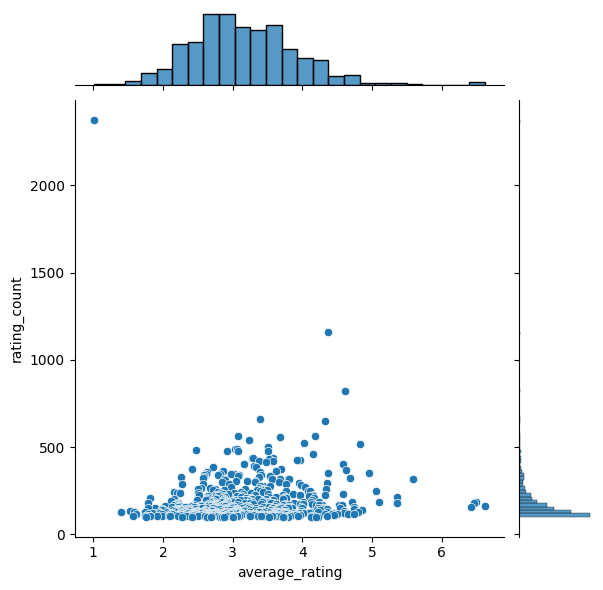

In [ ]:
sns.jointplot(x='average_rating', y='rating_count', data=ratings_100.toPandas())

In [ ]:
merge2 = ratings_100.join(filtered_users_age, on=["ISBN", 'Book-Title'], how="inner")

In [ ]:
merge2.show(5)

+----------+--------------------+------------+-------+-----------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+--------------------+---+
|      ISBN|          Book-Title|rating_count|User-ID|Book-Rating|  Book-Author|Year-Of-Publication|    Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|            Location|Age|
+----------+--------------------+------------+-------+-----------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+--------------------+---+
|0060173289|Divine Secrets of...|         112|    388|          0|Rebecca Wells|               1996|HarperCollins|http://images.ama...|http://images.ama...|http://images.ama...|nashville, tennes...| 35|
|0060173289|Divine Secrets of...|         112|   1559|         10|Rebecca Wells|               1996|HarperCollins|http://images.ama...|http://images.ama...|http://images.ama...|manchester,

In [ ]:
merge2.select([count(when(col(c).isNull(), c)).alias(c) for c in merge2.columns]).show()

+----+----------+------------+--------------+-------+-----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+
|ISBN|Book-Title|rating_count|average_rating|User-ID|Book-Rating|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|Location|Age|
+----+----------+------------+--------------+-------+-----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+
|   0|         0|           0|             0|      0|          0|          0|                  0|        0|          0|          0|          0|       0|  0|
+----+----------+------------+--------------+-------+-----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+



In [ ]:
merge3 = merge2.filter(col('Book-Rating') > 0)

In [ ]:
merge2.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113452 entries, 0 to 113451
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 113452 non-null  object 
 1   Book-Title           113452 non-null  object 
 2   rating_count         113452 non-null  int64  
 3   average_rating       113452 non-null  float64
 4   User-ID              113452 non-null  int32  
 5   Book-Rating          113452 non-null  int32  
 6   Book-Author          113452 non-null  object 
 7   Year-Of-Publication  113452 non-null  object 
 8   Publisher            113452 non-null  object 
 9   Image-URL-S          113452 non-null  object 
 10  Image-URL-M          113452 non-null  object 
 11  Image-URL-L          113452 non-null  object 
 12  Location             113452 non-null  object 
 13  Age                  113452 non-null  int32  
dtypes: float64(1), int32(3), int64(1), object(9)
memory usage: 10.8+ MB


#### **User-Book Matrix**

In [ ]:
# Create a list of unique users and books
user = sorted(merge2.select("User-ID").distinct().rdd.flatMap(lambda x: x).collect())
book = sorted(merge2.select("ISBN").distinct().rdd.flatMap(lambda x: x).collect())

# Create a dictionary to map user and book IDs to their index in the respective lists
user_map = {user_id: i for i, user_id in enumerate(user)}
book_map = {book_id: i for i, book_id in enumerate(book)}

# Create an empty matrix filled with 'NaN' values
matrix_data = [[None] * len(book) for _ in range(len(user))]

# Iterate through the data and fill in the matrix
for row in merge2.collect():
  user_index = user_map[row['User-ID']]
  book_index = book_map[row['ISBN']]
  matrix_data[user_index][book_index] = row['Book-Rating']


# Convert the list of lists to a Spark DataFrame
matrix_df = spark.createDataFrame(
  [([user[i]] + matrix_data[i]) for i in range(len(user))],
  ['User-ID'] + book
)

In [ ]:
matrix_df.show(50)

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

**Normalize user-item matrix**

In [ ]:
# prompt: Now from the matrix_df, subtract the rating by the mean rating of each user. the books with a rating less than the user's average rating get a negative value, and the books with a rating more than the user's average rating get a positive value.

from pyspark.sql.functions import mean, col

# Calculate the mean rating for each user
user_mean_ratings = matrix_df.groupBy("User-ID").agg(*[mean(col(c)).alias(f"avg({c})") for c in matrix_df.columns if c != "User-ID"])

# Subtract the mean rating from each rating in the matrix
normalized_matrix = matrix_df.join(user_mean_ratings, on="User-ID", how="inner").select(
    "User-ID",
    *[
        (col(c) - col(f"avg({c})")).alias(c)
        for c in matrix_df.columns
        if c != "User-ID"
    ]
)
normalized_matrix.show(50)

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

In [ ]:
matrix = merge2.groupBy

In [ ]:
matrix.show(50)

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

In [ ]:
merge2.filter((col("User-ID") == 186039) & (col('ISBN') == '0060096195')).show()

+----------+-----------------+------------+-------+-----------+------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+---+
|      ISBN|       Book-Title|rating_count|User-ID|Book-Rating| Book-Author|Year-Of-Publication| Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|            Location|Age|
+----------+-----------------+------------+-------+-----------+------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+---+
|0060096195|The Boy Next Door|         100| 186039|          0|Meggin Cabot|               2002|Avon Trade|http://images.ama...|http://images.ama...|http://images.ama...|tehran, tehran, iran| 24|
+----------+-----------------+------------+-------+-----------+------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+---+



### **Thử**

In [ ]:
merge2.groupBy('ISBN').count().count()

611

In [ ]:
user_item_matrix = merge2.groupBy("User-ID").pivot("ISBN").agg(mean("Book-Rating"))
user_item_matrix.show(50)

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-

## **User-based Collaborative Filtering (ver2)**

In [ ]:
filtered_users_age.filter(col('Book-Title').isNull()).count()

104564

In [ ]:
filtered_users_age.filter(col('Book-Rating') == 0).count()

658534

In [ ]:
filtered_users_age.count()

1043441

**Trước tiên lấy sách có trên 100 rating và bỏ sách k có title + rating = 0**

In [ ]:
filtered_title_rating = filtered_users_age.filter((col('Book-Rating') > 0)  & (col('Book-Title').isNotNull()))

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
filtered_title_rating.select([count(when(col(c).isNull(), c)).alias(c) for c in filtered_title_rating.columns]).show()

+-------+----+-----------+----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+
|User-ID|ISBN|Book-Rating|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|Location|Age|
+-------+----+-----------+----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+
|      0|   0|          0|         0|          1|                  0|        2|          0|          0|          1|       0|  0|
+-------+----+-----------+----------+-----------+-------------------+---------+-----------+-----------+-----------+--------+---+



In [ ]:
filtered_title_rating.count()

341736

**Còn có chưa đến 1/3 :))), thôi để  >= 50 thôi**

In [ ]:
filtered_title_rating = filtered_users_age

In [ ]:
filtered_title_rating_100 = filtered_title_rating \
                    .groupBy("ISBN", 'Book-Title') \
                    .agg(
                        count("Book-Rating").alias("rating_count")
                    ).filter(col("rating_count") >= 100)

In [ ]:
filtered_title_rating_100.show(20)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
filtered_title_rating_100_2 = filtered_title_rating_100.join(filtered_title_rating, on=["ISBN", 'Book-Title'], how="inner")

139626

## **Model-based Collaborative Filtering**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer

book_rating = merge1.select(
    "User-ID", "ISBN", "Book-Title", "Book-Rating")

# Create a StringIndexer to convert ISBN to numeric index
indexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_index")

# Fit the indexer on the data and transform it
indexed_data = indexer.fit(book_rating).transform(book_rating)

# Update book_rating to use the indexed ISBN column
book_rating = indexed_data.select("User-ID", "ISBN_index", "Book-Title", "Book-Rating") \
    .withColumnRenamed("ISBN_index", "ISBN")  # Rename for consistency

(training, test) = book_rating.randomSplit([0.8, 0.2])



In [ ]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=15, regParam=0.7, rank=55, userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
bookRecs = model.recommendForAllItems(10)

# Generate top 10 movie recommendations for a specified set of users
users_ALS = book_rating.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users_ALS, 10)
# Generate top 10 user recommendations for a specified set of movies
books_ALS = book_rating.select(als.getItemCol()).distinct().limit(3)
bookSubSetRecs = model.recommendForItemSubset(books_ALS, 10)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
book_rating

DataFrame[User-ID: int, ISBN: double, Book-Title: string, Book-Rating: int]

In [ ]:
userRecs.show(truncate=False)

+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User-ID|recommendations                                                                                                                                                           |
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{22, 8.380817}, {111, 8.320064}, {98, 8.180815}, {108, 8.169144}, {68, 8.142968}, {21, 8.110746}, {6, 8.09273}, {71, 8.066142}, {61, 8.03939}, {46, 8.034753}]           |
|165    |[{98, 8.833168}, {22, 8.748742}, {108, 8.74799}, {6, 8.661723}, {71, 8.6606045}, {68, 8.6594925}, {21, 8.615355}, {61, 8.613747}, {93, 8.60597}, {84, 8.585718}]          |
|243    |[{22, 8.886574}, {98, 8.8673525}, {108, 8.844108}, {68, 8.815473}, {21, 8.765397}, {6,

In [ ]:
bookRecs.show(truncate=False)

+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN|recommendations                                                                                                                                                                                                  |
+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|20  |[{130978, 9.234434}, {224257, 9.085471}, {162762, 9.085471}, {152318, 9.085471}, {141439, 9.085471}, {93427, 9.085471}, {47128, 9.085471}, {12917, 8.945583}, {203764, 8.927093}, {60185, 8.927093}]             |
|40  |[{107619, 9.042937}, {100902, 9.042937}, {77072, 9.042937}, {61899, 9.042937}, {43372, 9.042937}, {8853, 9.042937}, {237575, 8

In [ ]:
# Continue from your previous code after training the 'model' and having 'test' DataFrame

from pyspark.sql import functions as F
from pyspark.sql import Window # Although not strictly needed for manual calc, good practice

# --- Manual Calculation of Precision and Recall ---

print("\n--- Manual Calculation of Precision and Recall ---")

# Set the value of N for Top-N recommendations
N = 10

# 1. Get Top-N Recommendations for all users from the trained ALS model
# userRecs DataFrame has columns: User-ID, recommendations (list of (item_id, rating) tuples)
user_recs = model.recommendForAllUsers(N)

# Flatten the recommendations list to (User-ID, recommended_item_id) pairs
# Ensure item_id keeps its original type (DoubleType from StringIndexer)
recommended_items_flat = user_recs.select(
    als.getUserCol(),
    F.explode("recommendations").alias("rec") # Explode the list of tuples
).select(
    als.getUserCol(),
    F.col("rec." + als.getItemCol()).alias("item_id") # Extract item_id (which is ISBN)
)

print(f"Flattened Top-{N} recommendations:")
recommended_items_flat.limit(10).show()


# 2. Get Ground Truth items from the test set
# Flatten the test data to (User-ID, ground_truth_item_id) pairs
# Ensure item_id keeps its original type (DoubleType from StringIndexer)
ground_truth_items_flat = test.select(
    als.getUserCol(), # Chọn cột người dùng theo tên
    F.col(als.getItemCol()).alias("item_id") # <--- Sử dụng F.col() để lấy đối tượng cột trước khi gọi alias()
)

print("Flattened Ground Truth items from test set:")
ground_truth_items_flat.limit(10).show()



# 3. Find "Hits" - Recommended items that are also in the Ground Truth
# Join the flattened recommended and ground truth data on both User-ID and item_id
hits_df = recommended_items_flat.alias("rec").join(
    ground_truth_items_flat.alias("gt"),
    (F.col("rec." + als.getUserCol()) == F.col("gt." + als.getUserCol())) &
    (F.col("rec.item_id") == F.col("gt.item_id")),
    "inner" # Keep only the matching pairs (the hits)
)

print("Hits (Recommended and in Ground Truth):")
hits_df.limit(10).show()


# 4. Count Hits, Total Recommended, and Total Ground Truth per user

# Count the number of hits per user
hits_count_per_user = hits_df.groupBy(F.col("rec." + als.getUserCol())).agg(F.count(F.lit(1)).alias("hits")) # <--- Chỉ rõ nguồn User-ID ('rec')

# Count the total number of recommended items per user (should be N for most users)
# We can get this by grouping the flattened recommendations
recommended_count_per_user = recommended_items_flat.groupBy(als.getUserCol()).agg(F.count(F.lit(1)).alias("total_recommended"))

# Count the total number of ground truth items per user
ground_truth_count_per_user = ground_truth_items_flat.groupBy(als.getUserCol()).agg(F.count(F.lit(1)).alias("total_ground_truth"))


# 5. Calculate Precision and Recall per user and overall averages

# Join all counts together per user
metrics_per_user = recommended_count_per_user.alias("rec_c").join(
    ground_truth_count_per_user.alias("gt_c"),
    F.col("rec_c." + als.getUserCol()) == F.col("gt_c." + als.getUserCol()),
    "inner" # Only consider users present in both recommendations (from train) and ground truth (from test)
).join(
    hits_count_per_user.alias("h_c"),
    F.col("rec_c." + als.getUserCol()) == F.col("h_c." + als.getUserCol()),
    "left_outer" # Keep users with recommendations and ground truth, even if they have 0 hits
).select(
    F.col("rec_c." + als.getUserCol()).alias(als.getUserCol()),
    F.coalesce(F.col("h_c.hits"), F.lit(0.0)).alias("hits"), # Use 0.0 for users with no hits
    F.col("rec_c.total_recommended").alias("total_recommended"), # Should be N
    F.col("gt_c.total_ground_truth").alias("total_ground_truth") # Actual number of items in test
)

# Calculate Precision@N per user: hits / N
metrics_per_user = metrics_per_user.withColumn(
    "precision_at_N", F.col("hits") / F.col("total_recommended") # total_recommended should be N
)

# Calculate Recall@N per user: hits / total_ground_truth
# Avoid division by zero if a user has 0 ground truth items (though this should be handled by inner join earlier)
metrics_per_user = metrics_per_user.withColumn(
    "recall_at_N",
    F.when(F.col("total_ground_truth") > 0, F.col("hits") / F.col("total_ground_truth")).otherwise(0.0)
)

print(f"\nMetrics per user (sample):")
metrics_per_user.limit(10).show()


# Calculate the average Precision@N and Recall@N over all relevant users
# Average Precision is over all users who received recommendations (users in train)
average_precision_manual = metrics_per_user.agg(F.avg("precision_at_N")).collect()[0][0]

# Average Recall is typically calculated over users who have at least one item in the ground truth
average_recall_manual = metrics_per_user.filter(F.col("total_ground_truth") > 0).agg(F.avg("recall_at_N")).collect()[0][0]


print(f"\n--- Manual Evaluation Results (ALS Model) ---")
print(f"Precision@{N} on test set = {average_precision_manual:.4f}")
print(f"Recall@{N} on test set (for users with Ground Truth > 0) = {average_recall_manual:.4f}")


--- Manual Calculation of Precision and Recall ---
Flattened Top-10 recommendations:
+-------+-------+
|User-ID|item_id|
+-------+-------+
|     26|     22|
|     26|     98|
|     26|    108|
|     26|     21|
|     26|      6|
|     26|     71|
|     26|     61|
|     26|     46|
|     26|     68|
|     26|     50|
+-------+-------+

Flattened Ground Truth items from test set:
+-------+-------+
|User-ID|item_id|
+-------+-------+
|    243|  100.0|
|    254|   33.0|
|    254|   61.0|
|    256|   10.0|
|    638|    0.0|
|    638|   97.0|
|   1075|    0.0|
|   1161|   65.0|
|   1249|   25.0|
|   1433|   16.0|
+-------+-------+

Hits (Recommended and in Ground Truth):
+-------+-------+-------+-------+
|User-ID|item_id|User-ID|item_id|
+-------+-------+-------+-------+
|    254|     61|    254|   61.0|
|   2033|     61|   2033|   61.0|
|   9747|      6|   9747|    6.0|
|  20501|     61|  20501|   61.0|
|  20501|     93|  20501|   93.0|
|  21576|    108|  21576|  108.0|
|  23664|      6| 

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator # Không cần RankingEvaluator nữa
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row # Imported but not used
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F # Import Spark functions
# Import các kiểu dữ liệu cần thiết cho schema và thao tác mảng
from pyspark.sql.types import ArrayType, LongType, StructType, StructField, FloatType, DoubleType

# --- PHẦN 1: TẢI VÀ CHUẨN BỊ DỮ LIỆU ---

# Giả định 'filtered_title_rating_100_2' DataFrame đã tồn tại
print("Bắt đầu chuẩn bị dữ liệu...")
book_rating = filtered_title_rating_100_2.select(
    "User-ID", "ISBN", "Book-Title", "Book-Rating")

# Tạo StringIndexer để chuyển ISBN từ string sang ID số
indexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_index")

# Áp dụng StringIndexer
indexed_data = indexer.fit(book_rating).transform(book_rating)

# Cập nhật DataFrame để sử dụng cột ID số cho ISBN
# Đổi tên cột 'ISBN_index' thành 'ISBN' để khớp với tên tham số 'itemCol' trong ALS
# Lưu ý: Cột 'ISBN' sau dòng này chứa các ID số (thường là LongType), không phải string ISBN gốc
book_rating_indexed = indexed_data.select("User-ID", "ISBN_index", "Book-Title", "Book-Rating") \
    .withColumnRenamed("ISBN_index", "ISBN")

# Phân chia dữ liệu thành tập huấn luyện (training) và tập kiểm tra (test)
(training, test) = book_rating_indexed.randomSplit([0.8, 0.2], seed=123) # Thêm seed để kết quả chia được cố định
print("Chuẩn bị dữ liệu hoàn tất. Đã chia Train/Test.")

# --- PHẦN 2: HUẤN LUYỆN MÔ HÌNH ALS ---

# Xây dựng và cấu hình mô hình ALS
# als.getUserCol() -> "User-ID"
# als.getItemCol() -> "ISBN" (lúc này là cột ID số đã đổi tên)
# als.getRatingCol() -> "Book-Rating"
als = ALS(maxIter=15, regParam=0.7, rank=55, userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop") # 'drop' loại bỏ user/item trong test không có trong training

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
print("Bắt đầu huấn luyện mô hình ALS...")
model = als.fit(training)
print("Huấn luyện mô hình ALS hoàn tất.")


# --- PHẦN 3: ĐÁNH GIÁ MÔ HÌNH BẰNG RMSE ---

# Dự đoán rating trên tập test
print("Bắt đầu đánh giá bằng RMSE...")
predictions = model.transform(test)

# Đánh giá bằng RMSE
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                     predictionCol="prediction")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Kết quả đánh giá RMSE trên tập test = {rmse:.4f}")


# --- PHẦN 4: ĐÁNH GIÁ MÔ HÌNH BẰNG CÁC CHỈ SỐ XẾP HẠNG (Average Precision@k, Average Recall@k) ---

# 1. Xác định k cho đánh giá xếp hạng
# Chọn k = 10, giống như bạn đã dùng ở cuối code trước
k_eval = 10
# Xác định ngưỡng rating để coi là "phù hợp" (relevant) trong tập test
RELEVANCE_THRESHOLD = 7 # Ví dụ: rating từ 7 trở lên là phù hợp. Hãy điều chỉnh nếu cần.

print(f"\n--- Bắt đầu đánh giá xếp hạng thủ công (k={k_eval}, Ngưỡng Rating Phù Hợp >= {RELEVANCE_THRESHOLD}) ---")

# 2. Chuẩn bị Dữ liệu Thực tế Phù Hợp (Ground Truth) từ tập test
# Lọc các rating đạt ngưỡng phù hợp và thu thập ID sách thành mảng cho mỗi người dùng
# Cột 'ISBN' ở đây là ID số sau StringIndexer và đổi tên
ground_truth = test.filter(test["Book-Rating"] >= RELEVANCE_THRESHOLD) \
                   .groupBy("User-ID") \
                   .agg(F.collect_set("ISBN").alias("relevant_item_ids"))

# Hiển thị một vài dòng ground truth mẫu
print("Dữ liệu Thực tế Phù Hợp (Ground Truth) mẫu:")
ground_truth.limit(5).show(truncate=False)

# 3. Tạo Danh sách Gợi ý Top-k từ mô hình cho tất cả người dùng
# userRecs có cột 'recommendations' kiểu array<struct<ISBN: int, rating: float>> hoặc array<struct<item:long, rating:double>>
userRecs = model.recommendForAllUsers(k_eval)

# 4. Tính toán Precision@k và Recall@k trung bình (Cách thủ công)
# Trích xuất chỉ các ID sách (số) từ danh sách gợi ý và đảm bảo kiểu dữ liệu cho thao tác mảng
# Dựa vào lỗi gần nhất, có vẻ schema output thực tế là item:bigint(Long), rating:double
userRecs_ids = userRecs.withColumn("recommended_item_ids",
                                   F.col("recommendations").cast(ArrayType(StructType([StructField("item", LongType()), StructField("rating", DoubleType())])))) # Ép kiểu cho schema nội bộ
userRecs_ids = userRecs_ids.withColumn("recommended_item_ids",
                                   F.expr(f"transform(recommended_item_ids, x -> x.item)")) # Trích xuất ID sách (item)

# Ghép Ground Truth với Danh sách Gợi ý theo User-ID
# Sử dụng left_outer join để giữ lại tất cả người dùng có trong danh sách gợi ý
evaluation_data_manual = userRecs_ids.join(ground_truth, "User-ID", "left_outer") \
                                     .select("User-ID", "recommended_item_ids", "relevant_item_ids")

# Xử lý giá trị null bằng mảng rỗng để dễ tính toán
evaluation_data_manual = evaluation_data_manual.withColumn("recommended_item_ids", F.coalesce(F.col("recommended_item_ids"), F.array()))
evaluation_data_manual = evaluation_data_manual.withColumn("relevant_item_ids", F.coalesce(F.col("relevant_item_ids"), F.array()))

# Hiển thị dữ liệu ghép mẫu
print("\nDữ liệu sau khi ghép (Recommendations vs Ground Truth) mẫu:")
evaluation_data_manual.limit(5).show(truncate=False)


# Tính True Positives, Precision@k, và Recall@k cho từng người dùng
evaluation_results_manual = evaluation_data_manual.withColumn("true_positives",
                                                             F.size(F.array_intersect(F.col("recommended_item_ids"), F.col("relevant_item_ids")))) \
                                                 .withColumn("num_relevant", F.size("relevant_item_ids")) \
                                                 .withColumn("num_recommended", F.size("recommended_item_ids")) # Nên bằng k_eval

# Tính Precision và Recall cho từng người dùng (xử lý chia cho 0)
evaluation_results_manual = evaluation_results_manual.withColumn("precision_at_k",
                                                             F.when(F.col("num_recommended") > 0, F.col("true_positives") / F.col("num_recommended")).otherwise(0.0)) \
                                                 .withColumn("recall_at_k",
                                                             F.when(F.col("num_relevant") > 0, F.col("true_positives") / F.col("num_relevant")).otherwise(0.0))

# Tính Trung bình Precision@k và Recall@k trên toàn bộ người dùng
average_precision_at_k = evaluation_results_manual.agg(F.avg("precision_at_k")).collect()[0][0]
average_recall_at_k = evaluation_results_manual.agg(F.avg("recall_at_k")).collect()[0][0]

print(f"\n--- Kết quả Đánh giá Xếp hạng Thủ công (k={k_eval}, Ngưỡng Rating Phù Hợp >= {RELEVANCE_THRESHOLD}) ---")
print(f"Trung bình Precision@{k_eval}: {average_precision_at_k:.4f}")
print(f"Trung bình Recall@{k_eval}: {average_recall_at_k:.4f}")


# --- CÁC PHẦN TẠO RECOMMENDATION KHÁC (Code gốc của bạn - Tùy chọn) ---
# Bạn có thể giữ lại hoặc bỏ đi các phần này tùy mục đích

# # Generate top 10 user recommendations for each movie
# bookRecs = model.recommendForAllItems(10)

# # Generate top 10 movie recommendations for a specified set of users
# # Cần lấy từ book_rating_indexed vì cột ISBN (ID số) đã được đổi tên
# users_ALS = book_rating_indexed.select(als.getUserCol()).distinct().limit(3)
# userSubsetRecs = model.recommendForUserSubset(users_ALS, 10)

# # Generate top 10 user recommendations for a specified set of movies
# # Cần lấy từ book_rating_indexed
# books_ALS = book_rating_indexed.select(als.getItemCol()).distinct().limit(3)
# bookSubSetRecs = model.recommendForItemSubset(books_ALS, 10)

# print("\nĐã tạo các recommendation batch và subset (biến userRecs, bookRecs, userSubsetRecs, bookSubSetRecs).")

Bắt đầu chuẩn bị dữ liệu...
Chuẩn bị dữ liệu hoàn tất. Đã chia Train/Test.
Bắt đầu huấn luyện mô hình ALS...
Huấn luyện mô hình ALS hoàn tất.
Bắt đầu đánh giá bằng RMSE...
Kết quả đánh giá RMSE trên tập test = 1.9913

--- Bắt đầu đánh giá xếp hạng thủ công (k=10, Ngưỡng Rating Phù Hợp >= 7) ---
Dữ liệu Thực tế Phù Hợp (Ground Truth) mẫu:
+-------+-----------------+
|User-ID|relevant_item_ids|
+-------+-----------------+
|114    |[8.0]            |
|243    |[11.0]           |
|254    |[33.0]           |
|280    |[14.0]           |
|367    |[111.0]          |
+-------+-----------------+


Dữ liệu sau khi ghép (Recommendations vs Ground Truth) mẫu:
+-------+-----------------------------------------+-----------------+
|User-ID|recommended_item_ids                     |relevant_item_ids|
+-------+-----------------------------------------+-----------------+
|243    |[22, 108, 98, 6, 68, 71, 21, 61, 84, 46] |[11.0]           |
|26     |[22, 98, 108, 68, 6, 71, 21, 111, 84, 46]|[]             

In [ ]:
pickle.dump(userRecs.toPandas(), open('userRecs.pkl', 'wb'))

In [ ]:
pickle.dump(bookRecs.toPandas(), open('bookRecs.pkl', 'wb'))

In [ ]:
from pyspark.sql.functions import when

userRecs = userRecs.withColumn(
    "recommendations",
    when(col("recommendations.rating") > 10, 10).otherwise(col("recommendations.rating"))  # Assuming the rating field is named "rating"
)